In [ ]:
!pip install tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successful

# Install and Import Necessary Libraries

In [1]:
!pip install seaborn
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import joblib
import mne

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from scipy.stats import pearsonr
from scipy.fft import fft
from tabulate import tabulate

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ELU, ReLU

from tensorflow import keras
print(tf.version.VERSION)

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.17.0
Mounted at /content/drive


In [3]:
def set_seed(seed: int = 42) -> None:

  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

set_seed(42) #attach weights and biases citation

#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy

Random seed set as 42


# Directories (Local and Google Drive)

In [4]:
#local Drive

#seg_dir = r'C://Users//123100025//Downloads//h_seg_data' #segmented EEG files
#seg_label_dir = r'C://Users//123100025//Downloads//h_seg_data/segment_labels' #EEG labels

#google drive
seg_dir = '/content/drive/MyDrive/h_seg_data' #segmented EEG files
seg_label_dir = '/content/drive/MyDrive/h_seg_data/segment_labels' #EEG labels

# Load The Data

In [5]:
#initialize lists to store the loaded files
eeg_segments = []
eeg_labels = []

#check if the segment directory exists
if os.path.exists(seg_dir):

    #list the files/folders within the directory
    files = os.listdir(seg_dir)
    print(f"The folder consists of the following files:\n{files}")

    #for each patient ID from 1 to 79
    for p_id in range(1, 80):

        #define the paths for patient wise EEG segments and labels
        segment_fpath = os.path.join(seg_dir, f'eeg{p_id}_segments.npy')
        label_fpath = os.path.join(seg_label_dir, f'eeg{p_id}_labels.npy')

        #check if the segment and label files for that patient ID exist in their respective paths
        if os.path.exists(segment_fpath) and os.path.exists(label_fpath):

            #load the segments and labels
            segment = np.load(segment_fpath)
            label = np.load(label_fpath)

            #add it to their corresponding lists
            eeg_segments.append(segment)
            eeg_labels.append(label)

        #if the file for that patient ID doesn't exist
        else:

            print(f"Patient file {p_id} missing.")

    #stack the 3D arrays vertically
    eeg_segments = np.vstack(eeg_segments)
    #combine all the labels one after another
    eeg_labels = np.concatenate(eeg_labels, axis = 0)

    #transpose the array to the shape [samples, time steps, channels]
    eeg_Tsegments = np.transpose(eeg_segments, (0, 2, 1))

    print(f'Original EEG Segments shape: {eeg_segments.shape}')
    print(f'Transposed EEG Segments shape: {eeg_Tsegments.shape}')

else:

    print("Directory doesn't exist.")

The folder consists of the following files:
['eeg2_segments.npy', 'eeg1_segments.npy', 'eeg4_segments.npy', 'eeg3_segments.npy', 'eeg5_segments.npy', 'eeg6_segments.npy', 'eeg7_segments.npy', 'eeg8_segments.npy', 'eeg9_segments.npy', 'eeg10_segments.npy', 'eeg11_segments.npy', 'eeg12_segments.npy', 'eeg13_segments.npy', 'eeg14_segments.npy', 'eeg15_segments.npy', 'eeg16_segments.npy', 'eeg18_segments.npy', 'eeg17_segments.npy', 'eeg20_segments.npy', 'eeg19_segments.npy', 'eeg21_segments.npy', 'eeg23_segments.npy', 'eeg22_segments.npy', 'eeg24_segments.npy', 'eeg26_segments.npy', 'eeg25_segments.npy', 'eeg27_segments.npy', 'eeg28_segments.npy', 'eeg29_segments.npy', 'eeg30_segments.npy', 'eeg31_segments.npy', 'eeg33_segments.npy', 'eeg32_segments.npy', 'eeg34_segments.npy', 'eeg36_segments.npy', 'eeg35_segments.npy', 'eeg37_segments.npy', 'eeg38_segments.npy', 'eeg39_segments.npy', 'eeg40_segments.npy', 'eeg41_segments.npy', 'eeg42_segments.npy', 'eeg43_segments.npy', 'eeg44_segments.np

# Split The Data


In [6]:
#split data into training (80%) and test (20%) sets
train_seg, test_seg, train_labels, test_labels = train_test_split(eeg_Tsegments,
                                                                  eeg_labels,
                                                                  test_size=0.2,
                                                                  random_state=42,
                                                                  stratify=eeg_labels)

#split the training data into 70% train and 10% validation
x_train, val_seg, y_train, val_labels = train_test_split(train_seg,
                                                         train_labels,
                                                         test_size=0.125,
                                                         random_state=42,
                                                         stratify=train_labels)

#split the remaining training set into 20% labelled set (x_train_lseg) and 50% unlabelled set
#(assume for pseudo labelling process) (x_train_unseg)
x_train_lseg, x_train_unseg, y_train_labels, y_train_unlabels = train_test_split(x_train,
                                                                                 y_train,
                                                                                 test_size=0.715,
                                                                                 random_state=42,
                                                                                 stratify=y_train)

print(f'\nEntire data shape: {eeg_Tsegments.shape}') #100% data
print(f'\nEntire Labels Shape: {eeg_labels.shape}')

print(f'Training Data Shape: {x_train.shape}') #80% train
print(f'Training Labels Shape: {y_train.shape}')

print(f"Test data shape: {test_seg.shape}") #20% test
print(f"Test labels shape: {test_labels.shape}")

print(f'Validation Data Shape: {val_seg.shape}') #10% validation during training
print(f'Validation Labels Shape: {val_labels.shape}')

print(f"\nLabelled training data shape: {x_train_lseg.shape}") #20% labelled training set
print(f"\nLabelled training labels shape: {y_train_labels.shape}")

print(f"Unlabelled training data shape: {x_train_unseg.shape}") #50% unlabelled training set
print(f"Unlabelled training labels shape: {y_train_unlabels.shape}")


Entire data shape: (100441, 1024, 18)

Entire Labels Shape: (100441,)
Training Data Shape: (70308, 1024, 18)
Training Labels Shape: (70308,)
Test data shape: (20089, 1024, 18)
Test labels shape: (20089,)
Validation Data Shape: (10044, 1024, 18)
Validation Labels Shape: (10044,)

Labelled training data shape: (20037, 1024, 18)

Labelled training labels shape: (20037,)
Unlabelled training data shape: (50271, 1024, 18)
Unlabelled training labels shape: (50271,)


Class Distribution of the Entire Dataset: Counter({0: 87650, 1: 12791})
Total Number of Data Samples = 100441
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


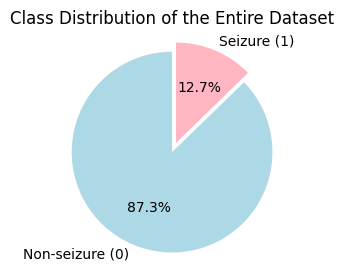

Class Distribution of the Labelled Training Dataset: Counter({0: 17485, 1: 2552})
Total Number of Data Samples = 20037
Non-seizure class distribution =  87.26%
Seizure class distribution = 12.74%


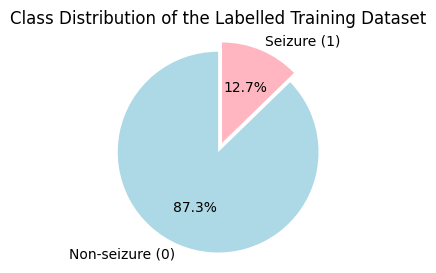

Class Distribution of the Unlabelled Training Dataset: Counter({0: 43869, 1: 6402})
Total Number of Data Samples = 50271
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


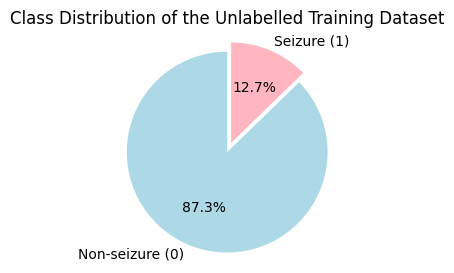

Class Distribution of the Validation Dataset: Counter({0: 8765, 1: 1279})
Total Number of Data Samples = 10044
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


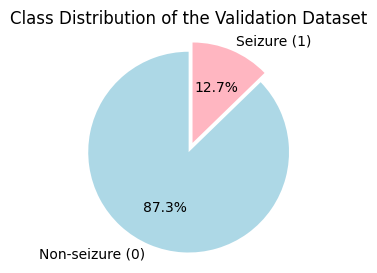

Class Distribution of the Test Dataset: Counter({0: 17531, 1: 2558})
Total Number of Data Samples = 20089
Non-seizure class distribution =  87.27%
Seizure class distribution = 12.73%


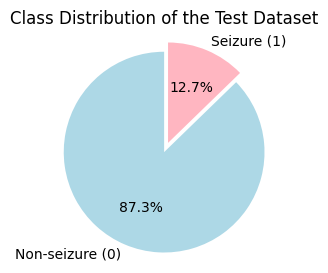

In [7]:
#function to calculate the class imbalances across the datasets
def data_balance(dataset, name):

    #count the occurences of each class
    samples_counter = Counter(dataset)
    print(f'Class Distribution of the {name}: {samples_counter}')

    #calculate the distribution
    total_samples = len(dataset)
    class_0 = (samples_counter[0] / total_samples) * 100 #nonseizure
    class_1 = (samples_counter[1] / total_samples) * 100 #seizure

    print(f'Total Number of Data Samples = {total_samples}')
    print(f'Non-seizure class distribution =  {class_0:.2f}%')
    print(f'Seizure class distribution = {class_1:.2f}%')

    #plot the distribution
    labels = ['Non-seizure (0)', 'Seizure (1)']
    sizes = [class_0, class_1]
    colors = ['lightblue', 'lightpink']
    explode = (0, 0.1)

    plt.figure(figsize=(3,3))

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal') #circle
    plt.title(f'Class Distribution of the {name}')
    plt.show()

data_balance(eeg_labels, "Entire Dataset")
data_balance(y_train_labels, "Labelled Training Dataset")
data_balance(y_train_unlabels, "Unlabelled Training Dataset")
data_balance(val_labels, "Validation Dataset")
data_balance(test_labels, "Test Dataset")

# Base Model and Ideal Model

## Build The Model

In [12]:
#define the 1D CNN model
def CNN_1D(input_shape):

    model = Sequential()

    #layer 1
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=input_shape))

    #layer2
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

    #layer3
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer4
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    #layer5
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())

    model.add(GlobalMaxPooling1D())

    model.add(Flatten())

    #dense layer1
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))

    #dense layer2
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    #output dense layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

input_shape = (x_train_lseg.shape[1], x_train_lseg.shape[2])
model = CNN_1D(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 1022, 32)            │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 1020, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 1018, 32)            │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1018, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 1016, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1016, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 1014, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1014, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,793 (116.38 KB)

 Trainable params: 29,473 (115.13 KB)

 Non-trainable params: 320 (1.25 KB)

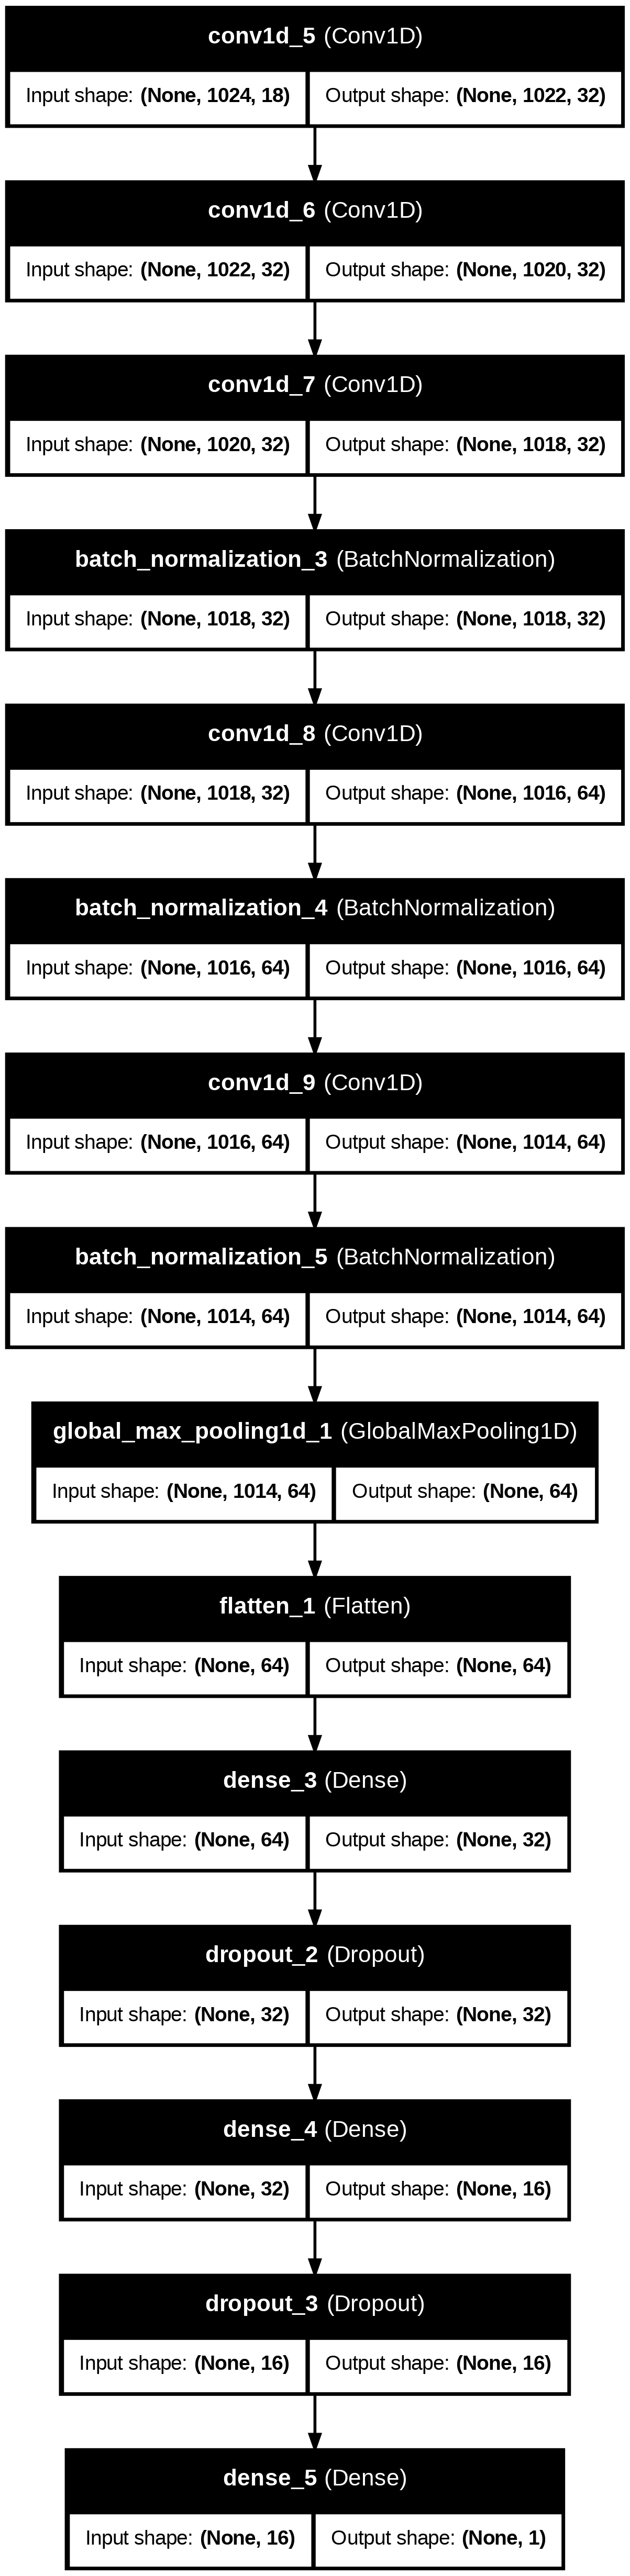

In [13]:
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

## Load and Evaluate The Base Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8895 - loss: 0.2637
Test Loss: 0.2545, Test Accuracy: 0.8929
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Pearson Correlation Coefficient: 0.6845
Matthews Correlation Coefficient : 0.6181
AUC-ROC: 0.9354


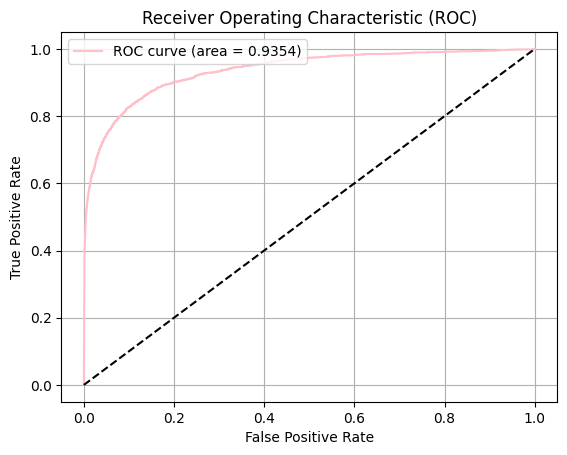

In [14]:
#load the base model
base_model = tf.keras.models.load_model('base_model.h5')

#evaluate the model
test_loss, test_acc = base_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

#predictions and probabilities
test_probs = base_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Load and Evaluate The Ideal Model

628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9439 - loss: 0.1573
Test Loss: 0.1505, Test Accuracy: 0.9449%
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Pearson Correlation Coefficient: 0.8049
Matthews Correlation Coefficient : 0.7555
AUC-ROC: 0.9693


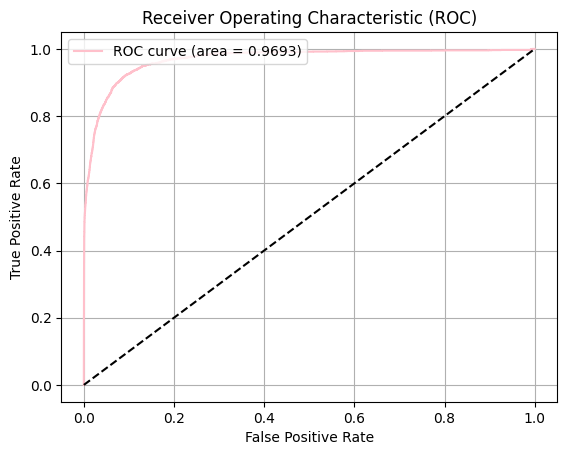

In [15]:
#load the base model
ideal_model = tf.keras.models.load_model('ideal_model.h5')

# Evaluate the model
test_loss, test_acc = ideal_model.evaluate(test_seg, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}%")

#predictions and probabilities
test_probs = ideal_model.predict(test_seg).ravel()
test_preds = (test_probs > 0.5).astype(int)

#Pearson correlation coefficient
pcc = pearsonr(test_probs, test_labels)[0]
print(f"Pearson Correlation Coefficient: {pcc:.4f}")

#Matthews correlation coefficient
mcc = matthews_corrcoef(test_labels, test_preds)
print(f"Matthews Correlation Coefficient : {mcc:.4f}")

#AUC-ROC
auc = roc_auc_score(test_labels, test_probs)
print(f"AUC-ROC: {auc:.4f}")

fpr, tpr, _ = roc_curve(test_labels, test_probs)

#plot ROC Curve
plt.figure()
plt.plot(fpr, tpr,  color='pink', label=f'ROC curve (area = {auc:.4f})')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Experiments Dictionary

In [16]:
experiments = {

#conf threshold no reclassification

    #exp 1 - Taking all the labels above the defined confidence threshold, no reclassification
    'exp_1': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 2 - Taking all the seizure labels above the defined threshold and an equal number of confident nonseizure labels, no reclassification
    'exp_2': {'conf_thresh': 0.99,
              'add_both': True,
              'equal': True,
              'seizure_only': False,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 3 - Taking all the seizure labels above the defined threshold only, no reclassification
    'exp_3': {'conf_thresh': 0.99,
              'add_both': False,
              'equal': False,
              'seizure_only': True,
              'nonseizure_only': False,
              'reclassify': False,
              'fixed_percentage': None},

    #exp 4 - Taking all the nonseizure labels below the defined threshold only, no reclassification
    'exp_4': {'conf_thresh': 0.01,
              'add_both': False,
              'equal': False,
              'seizure_only': False,
              'nonseizure_only': True,
              'reclassify': False,
              'fixed_percentage': None}}

In [17]:
#track the performance metrics

metrics_history = {'Iteration': [],
                   'Number of Confident Indices Added': [],
                    'Train Accuracy': [],
                    'Train Loss': [],
                    'Validation Accuracy': [],
                    'Validation Loss': [],
                    'Validation PCC': [],
                    'Validation MCC': [],
                    'Validation AUC': [],
                    'Test Accuracy': [],
                    'Test Loss': [],
                    'Test PCC': [],
                    'Test MCC': [],
                    'Test AUC': []
}

#track the segment indices = with their predicted pseudo labels
pseudo_labelled_segments = {
    'Indices': [],
    'Predicted Labels': [],
    'Confidence Values': []
}

correct_seizures = []
correct_nonseizures = []

#initialize the variables
i = 0
prev_mcc = 0
best_mcc = 0
#mcc_drop_count = 0
#max_mcc_drops = 3

#store augmented models based on the iteration round
augmented_model_v = {}
best_augmented_model = None

#original training model, labelled and unlabelled training set
iter_base_model = base_model
iter_unlabelled_segments = x_train_unseg

#number of iterations
num_iterations = 10

#store AUC-ROC data
val_roc_curves = {
    'fpr': [],
    'tpr': [],
    'val_auc': []
}

test_roc_curves = {
    'fpr': [],
    'tpr': [],
    'test_auc': []
}

# Functions

In [18]:
#function to select confident pseudo labels based on the mode of the experiment

def pseudo_labeling(i,iter_base_model, unlabelled_data,
                    conf_thresh=None, fixed_percentage=None,
                    add_both=False, equal= False,
                    seizure_only=False, nonseizure_only=False):

    conf_indices = []
    conf_segments = []
    conf_labels = []
    conf_values = []

    #model predictions on the unlabelled data
    predictions = iter_base_model.predict(unlabelled_data).ravel()
    predicted_labels = (predictions > 0.5).astype(int)

    if conf_thresh is not None:

        if add_both == True:

            if equal == False: #for exp1

                #select the most confident indices
                conf_indices = np.where((predictions > conf_thresh) | (predictions < (1 - conf_thresh)))[0] #conf_thresh = 0.99

            if equal == True: #for exp2

                #select the most confident seizure indices
                conf_seizure_indices = np.where((predictions > conf_thresh))[0] #conf_thresh = 0.99

                #count the number of conf seizure indices
                count_seizure_indices = len(conf_seizure_indices)

                #select an equal number of confident nonseizure indices
                conf_nonseizure_indices = np.where(predictions < (1 - conf_thresh))[0] #conf_thresh = 0.99
                conf_nonseizure_indices = conf_nonseizure_indices[:count_seizure_indices]

                #combine the indices
                conf_indices = np.concatenate((conf_seizure_indices, conf_nonseizure_indices))

        elif seizure_only == True: #for exp3

            #select the most confident seizure indices
            conf_indices = np.where((predictions > conf_thresh))[0] #conf_thresh = 0.99

        elif nonseizure_only == True: #for exp4

            #select the most confident non-seizure indices
            conf_indices = np.where((predictions < conf_thresh))[0] #conf_thresh = 0.01

    elif fixed_percentage is not None:

        #cumulative fixed percentage calculation
        cumulative_percentage = fixed_percentage * i

        if add_both == True and equal == True: #for exp9

            #calculate the number of seizure and non-seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions) #descending order
            seizure_indices = seizure_indices[:num_indices]

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions) #ascending order
            nonseizure_indices = nonseizure_indices[:num_indices]

            #combine the indices
            conf_indices = np.concatenate((seizure_indices, nonseizure_indices))

        if add_both == True and equal == False:  # for exp12 and 13

            #calculate the total number of indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #calculate the number of seizure and non-seizure indices based on the desired proportions
            num_seizure_indices = int(num_indices * 0.87)  #87% for seizures
            num_nonseizure_indices = num_indices - num_seizure_indices  #remaining 13% for non-seizures

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions)  #descending order
            seizure_indices = seizure_indices[:num_seizure_indices]

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions)  #ascending order
            nonseizure_indices = nonseizure_indices[:num_nonseizure_indices]

            #combine the indices
            conf_indices = np.concatenate((seizure_indices, nonseizure_indices))

        elif seizure_only == True: #for exp10

            #calculate the number of seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident seizure indices
            seizure_indices = np.argsort(-predictions) #descending order
            seizure_indices = seizure_indices[:num_indices]

            #combine the indices
            conf_indices = seizure_indices

        elif nonseizure_only == True: #for exp11

            #calculate the number of non-seizure indices to add
            total_unlabelled_data = unlabelled_data.shape[0]
            num_indices = int(total_unlabelled_data * cumulative_percentage)

            #sort the probability indices

            #select the most confident non-seizure indices
            nonseizure_indices = np.argsort(predictions) #ascending order
            nonseizure_indices = nonseizure_indices[:num_indices]

            #combine the indices
            conf_indices = nonseizure_indices

    conf_segments = unlabelled_data[conf_indices]
    conf_labels = predicted_labels[conf_indices]
    conf_values = predictions[conf_indices]

    return conf_indices, conf_segments, conf_labels, conf_values


In [19]:
#function to update the pseudo labels df to comapre b/w predicted and actual labels

def overwrite_pseudo_labels(conf_indices, conf_labels, conf_values, pseudo_labelled_segments, reclassify):

    if reclassify == False: #since there is no reclassification, pseudo labelled segments are iterativly deleted as they get added to the training data
        #so no repeated segments with multiple labels
        pseudo_labelled_segments['Indices'].extend(conf_indices)
        pseudo_labelled_segments['Predicted Labels'].extend(conf_labels)
        pseudo_labelled_segments['Confidence Values'].extend(conf_values)

    elif reclassify == True: #complete overwrite mode

        for idx in enumerate(conf_indices):

            idx = idx[0]

            if idx not in pseudo_labelled_segments['Indices']: #for iteration 1 or unique indices
                pseudo_labelled_segments['Indices'].append(idx)
                pseudo_labelled_segments['Predicted Labels'].append(conf_labels[idx])
                pseudo_labelled_segments['Confidence Values'].append(conf_values[idx])

            else: #to avoid repeated indices with multiple labels
                pseudo_labelled_segments['Predicted Labels'][pseudo_labelled_segments['Indices'].index(idx)] = conf_labels[idx]
                pseudo_labelled_segments['Confidence Values'][pseudo_labelled_segments['Indices'].index(idx)] = conf_values[idx]

    return pseudo_labelled_segments


In [20]:
#function to retrain the augmented models on the new combined training data

def retrain_model(i,
                  augmented_model,
                  x_train_lseg, y_train_labels,
                  conf_segments, conf_labels,
                  augmented_segments, augmented_labels,
                  iter_base_model,
                  val_seg, val_labels,
                  reclassify):

    if reclassify == False:

        if i == 1:  # First iteration

            augmented_segments = np.concatenate((x_train_lseg, conf_segments))
            augmented_labels = np.concatenate((y_train_labels, conf_labels))

        else:
            #append new pseudo-labels to the existing ones
            augmented_segments = np.concatenate((augmented_segments, conf_segments))
            augmented_labels = np.concatenate((augmented_labels, conf_labels))

    elif reclassify == True:

        #combine labelled data with current pseudo-labelled data only
        augmented_segments = np.concatenate((x_train_lseg, conf_segments))
        augmented_labels = np.concatenate((y_train_labels, conf_labels))

    #Reinitialize to create a new augmented model
    input_shape = (augmented_segments.shape[1], augmented_segments.shape[2])
    augmented_model = CNN_1D(input_shape)

    #set model weights to the base model's weights
    #augmented_model.set_weights(iter_base_model.get_weights())

    #augmented_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    #calculate class weights for the combined training set
    class_pweights = class_weight.compute_class_weight(
        class_weight = 'balanced',
        classes= np.unique(augmented_labels),
        y = augmented_labels
    )

    cw_pdict = {0: class_pweights[0], 1: class_pweights[1]}

    #train the model with the class weights

    phistory = augmented_model.fit(augmented_segments,
                                   augmented_labels,
                                   epochs = 30,
                                   batch_size = 32,
                                   validation_data = (val_seg, val_labels),
                                   class_weight = cw_pdict)

    return augmented_model, augmented_segments, augmented_labels


In [21]:
#function to evaluate and update the model performance df

def evaluate_model(conf_indices, augmented_model, augmented_segments, augmented_labels,
                   val_seg, val_labels, test_seg, test_labels,
                   metrics_history,
                   val_roc_curves, test_roc_curves,i):

    #model evaluation on the training and validation sets

    train_predictions = augmented_model.predict(augmented_segments).ravel()
    train_predicted_labels = (train_predictions > 0.5).astype(int)

    val_predictions = augmented_model.predict(val_seg).ravel()
    val_predicted_labels = (val_predictions > 0.5).astype(int)

    #calculate the performance metrics

    train_acc = accuracy_score(augmented_labels, train_predicted_labels)
    val_acc = accuracy_score(val_labels, val_predicted_labels)
    train_loss = augmented_model.evaluate(augmented_segments, augmented_labels)[0]
    val_loss = augmented_model.evaluate(val_seg, val_labels)[0]
    val_pcc = pearsonr(val_predictions, val_labels)[0]
    val_mcc = matthews_corrcoef(val_labels, val_predicted_labels)
    val_auc = roc_auc_score(val_labels, val_predictions)

    fpr, tpr, _ = roc_curve(val_labels, val_predictions)

    #store the fpr, tpr, and roc_auc for each iteration
    val_roc_curves['fpr'].append(fpr)
    val_roc_curves['tpr'].append(tpr)
    val_roc_curves['val_auc'].append(val_auc)

    #model evaluation on the test data

    test_loss, test_acc = augmented_model.evaluate(test_seg, test_labels)

    #predictions and probabilities
    test_predictions = augmented_model.predict(test_seg).ravel()
    test_predicted_labels = (test_predictions > 0.5).astype(int)

    #Pearson correlation coefficient
    test_pcc = pearsonr(test_predictions, test_labels)[0]

    #Matthews correlation coefficient
    test_mcc = matthews_corrcoef(test_labels, test_predicted_labels)

    #AUC-ROC
    test_auc = roc_auc_score(test_labels, test_predictions)

    fpr, tpr, _ = roc_curve(test_labels, test_predictions)

    num_conf_indices = len(conf_indices)

    #store the fpr, tpr, and roc_auc for each iteration
    test_roc_curves['fpr'].append(fpr)
    test_roc_curves['tpr'].append(tpr)
    test_roc_curves['test_auc'].append(test_auc)

    metrics_history['Iteration'].append(i)
    metrics_history['Number of Confident Indices Added'].append(num_conf_indices)
    metrics_history['Train Accuracy'].append(train_acc)
    metrics_history['Train Loss'].append(train_loss)
    metrics_history['Validation Accuracy'].append(val_acc)
    metrics_history['Validation Loss'].append(val_loss)
    metrics_history['Validation PCC'].append(val_pcc)
    metrics_history['Validation MCC'].append(val_mcc)
    metrics_history['Validation AUC'].append(val_auc)

    metrics_history['Test Accuracy'].append(test_acc)
    metrics_history['Test Loss'].append(test_loss)
    metrics_history['Test PCC'].append(test_pcc)
    metrics_history['Test MCC'].append(test_mcc)
    metrics_history['Test AUC'].append(test_auc)

    return metrics_history, val_roc_curves, test_roc_curves


# Experiments Main Run

## Experiment 1

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_1']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp1.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp1.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp1.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp1.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp1.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 1.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp1.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp1.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step

Number of confident indices: 19797
Number of confident pseudo-labelled segments = 19797 out of 50271
Percentage of confident pseudo labels = 39.38%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - accuracy: 0.6437 - loss: 0.6682 - val_accuracy: 0.9013 - val_loss: 0.4071
Epoch 2/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8541 - loss: 0.4551 - val_accuracy: 0.8596 - val_loss: 0.3670
Epoch 3/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8741 - loss: 0.3595 - val_accuracy: 0.8973 - val_loss: 0.3063
Epoch 4/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.8902 - loss: 0.3135 - val_accuracy: 0.8820 - val_loss: 0.3060
Epoch 5/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9017 - loss: 0.2882 - val_accuracy: 0.8670 - val_loss: 0.3249
Epoch 6/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9067 - loss: 0.2687 - val_accuracy: 0.8427 - val_loss: 0.3547
Epoch 7/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9166 - loss: 0.2466 - val_accuracy: 0.8535 - val_loss: 0.3187
Epoch 8/30
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.9078 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.6184 - loss: 0.7531 - val_accuracy: 0.8501 - val_loss: 0.3883
Epoch 2/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8444 - loss: 0.4331 - val_accuracy: 0.8960 - val_loss: 0.3372
Epoch 3/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8908 - loss: 0.3384 - val_accuracy: 0.8980 - val_loss: 0.3167
Epoch 4/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9073 - loss: 0.3120 - val_accuracy: 0.8979 - val_loss: 0.2931
Epoch 5/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9128 - loss: 0.2868 - val_accuracy: 0.9102 - val_loss: 0.2828
Epoch 6/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9170 - loss: 0.2594 - val_accuracy: 0.8771 - val_loss: 0.3119
Epoch 7/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.9202 - loss: 0.2505 - val_accuracy: 0.9031 - val_loss: 0.2553
Epoch 8/30
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.9195 -

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.5579 - loss: 0.8935 - val_accuracy: 0.8453 - val_loss: 0.4361
Epoch 2/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.8785 - loss: 0.3700 - val_accuracy: 0.8479 - val_loss: 0.3998
Epoch 3/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9168 - loss: 0.3072 - val_accuracy: 0.8945 - val_loss: 0.3452
Epoch 4/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9199 - loss: 0.2838 - val_accuracy: 0.8977 - val_loss: 0.2931
Epoch 5/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9281 - loss: 0.2647 - val_accuracy: 0.8913 - val_loss: 0.2924
Epoch 6/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9136 - loss: 0.2544 - val_accuracy: 0.9134 - val_loss: 0.2359
Epoch 7/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step - accuracy: 0.9202 - loss: 0.2373 - val_accuracy: 0.9003 - val_loss: 0.2467
Epoch 8/30
1780/1780 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.9186 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5650 - loss: 0.6950 - val_accuracy: 0.9095 - val_loss: 0.3697
Epoch 2/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 66s 35ms/step - accuracy: 0.9044 - loss: 0.3788 - val_accuracy: 0.9120 - val_loss: 0.3069
Epoch 3/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9269 - loss: 0.3091 - val_accuracy: 0.9265 - val_loss: 0.2539
Epoch 4/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9313 - loss: 0.2928 - val_accuracy: 0.9216 - val_loss: 0.2535
Epoch 5/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - accuracy: 0.9360 - loss: 0.2654 - val_accuracy: 0.9277 - val_loss: 0.2384
Epoch 6/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9310 - loss: 0.2566 - val_accuracy: 0.9291 - val_loss: 0.2267
Epoch 7/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9326 - loss: 0.2334 - val_accuracy: 0.9178 - val_loss: 0.2511
Epoch 8/30
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.9377 -

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5562 - loss: 0.6881 - val_accuracy: 0.8841 - val_loss: 0.3408
Epoch 2/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.8914 - loss: 0.3711 - val_accuracy: 0.9010 - val_loss: 0.3251
Epoch 3/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9122 - loss: 0.3009 - val_accuracy: 0.8743 - val_loss: 0.3502
Epoch 4/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9208 - loss: 0.2582 - val_accuracy: 0.9319 - val_loss: 0.2230
Epoch 5/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9284 - loss: 0.2425 - val_accuracy: 0.9239 - val_loss: 0.2325
Epoch 6/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9280 - loss: 0.2345 - val_accuracy: 0.9202 - val_loss: 0.2431
Epoch 7/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - accuracy: 0.9361 - loss: 0.2201 - val_accuracy: 0.9281 - val_loss: 0.2107
Epoch 8/30
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9390 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 89s 39ms/step - accuracy: 0.6478 - loss: 0.7549 - val_accuracy: 0.9091 - val_loss: 0.3263
Epoch 2/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 70s 36ms/step - accuracy: 0.9058 - loss: 0.3358 - val_accuracy: 0.9059 - val_loss: 0.3379
Epoch 3/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9201 - loss: 0.2929 - val_accuracy: 0.9115 - val_loss: 0.3243
Epoch 4/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9232 - loss: 0.2697 - val_accuracy: 0.9206 - val_loss: 0.2781
Epoch 5/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - accuracy: 0.9333 - loss: 0.2490 - val_accuracy: 0.9308 - val_loss: 0.2478
Epoch 6/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9352 - loss: 0.2386 - val_accuracy: 0.9206 - val_loss: 0.2574
Epoch 7/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9369 - loss: 0.2239 - val_accuracy: 0.9161 - val_loss: 0.2582
Epoch 8/30
1974/1974 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9414 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.7079 - loss: 0.6032 - val_accuracy: 0.9088 - val_loss: 0.2823
Epoch 2/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.9164 - loss: 0.3193 - val_accuracy: 0.9178 - val_loss: 0.2857
Epoch 3/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9266 - loss: 0.2793 - val_accuracy: 0.9320 - val_loss: 0.2611
Epoch 4/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.9298 - loss: 0.2559 - val_accuracy: 0.9276 - val_loss: 0.2606
Epoch 5/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9357 - loss: 0.2400 - val_accuracy: 0.9027 - val_loss: 0.2950
Epoch 6/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9392 - loss: 0.2195 - val_accuracy: 0.8963 - val_loss: 0.3274
Epoch 7/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9423 - loss: 0.2077 - val_accuracy: 0.9213 - val_loss: 0.2610
Epoch 8/30
1985/1985 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9435 -

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.6219 - loss: 0.6144 - val_accuracy: 0.8959 - val_loss: 0.3534
Epoch 2/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - accuracy: 0.9086 - loss: 0.3279 - val_accuracy: 0.9234 - val_loss: 0.2326
Epoch 3/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.9277 - loss: 0.2790 - val_accuracy: 0.9280 - val_loss: 0.2161
Epoch 4/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - accuracy: 0.9281 - loss: 0.2635 - val_accuracy: 0.9241 - val_loss: 0.2326
Epoch 5/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9358 - loss: 0.2403 - val_accuracy: 0.9328 - val_loss: 0.1985
Epoch 6/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9389 - loss: 0.2270 - val_accuracy: 0.9354 - val_loss: 0.1963
Epoch 7/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9396 - loss: 0.2203 - val_accuracy: 0.9284 - val_loss: 0.2007
Epoch 8/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.9429 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.5602 - loss: 0.7361 - val_accuracy: 0.8998 - val_loss: 0.3527
Epoch 2/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.8988 - loss: 0.3487 - val_accuracy: 0.9223 - val_loss: 0.2875
Epoch 3/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9193 - loss: 0.3022 - val_accuracy: 0.9273 - val_loss: 0.2556
Epoch 4/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9262 - loss: 0.2690 - val_accuracy: 0.9268 - val_loss: 0.2413
Epoch 5/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9323 - loss: 0.2511 - val_accuracy: 0.9315 - val_loss: 0.2233
Epoch 6/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9370 - loss: 0.2314 - val_accuracy: 0.9319 - val_loss: 0.2256
Epoch 7/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9363 - loss: 0.2309 - val_accuracy: 0.9302 - val_loss: 0.2408
Epoch 8/30
2040/2040 ━━━━━━━━━━━━━━━━━━━━ 73s 36ms/step - accuracy: 0.9415 -

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.941

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 89s 39ms/step - accuracy: 0.6523 - loss: 0.7149 - val_accuracy: 0.8847 - val_loss: 0.3692
Epoch 2/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 72s 35ms/step - accuracy: 0.9048 - loss: 0.3425 - val_accuracy: 0.9252 - val_loss: 0.2384
Epoch 3/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9225 - loss: 0.2919 - val_accuracy: 0.9269 - val_loss: 0.2435
Epoch 4/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9306 - loss: 0.2692 - val_accuracy: 0.9311 - val_loss: 0.2386
Epoch 5/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9272 - loss: 0.2634 - val_accuracy: 0.9289 - val_loss: 0.2214
Epoch 6/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9312 - loss: 0.2474 - val_accuracy: 0.9322 - val_loss: 0.2282
Epoch 7/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9363 - loss: 0.2345 - val_accuracy: 0.9270 - val_loss: 0.2340
Epoch 8/30
2056/2056 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - accuracy: 0.9429 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               19797 |         0.969975 |    0.0750011 |              0.929211 |          0.197785 |         0.735068 |         0.677601 |         0.94

Number of unlabelled samples remaining: 4542
Iteration 10 complete. Test MCC: 0.7138934327155614, Best MCC so far: 0.7142702717013124
Best model found after 10 iterations with MCC: 0.7142702717013124

aug_model_v10 saved as the best augmented model of experiment 1.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+========

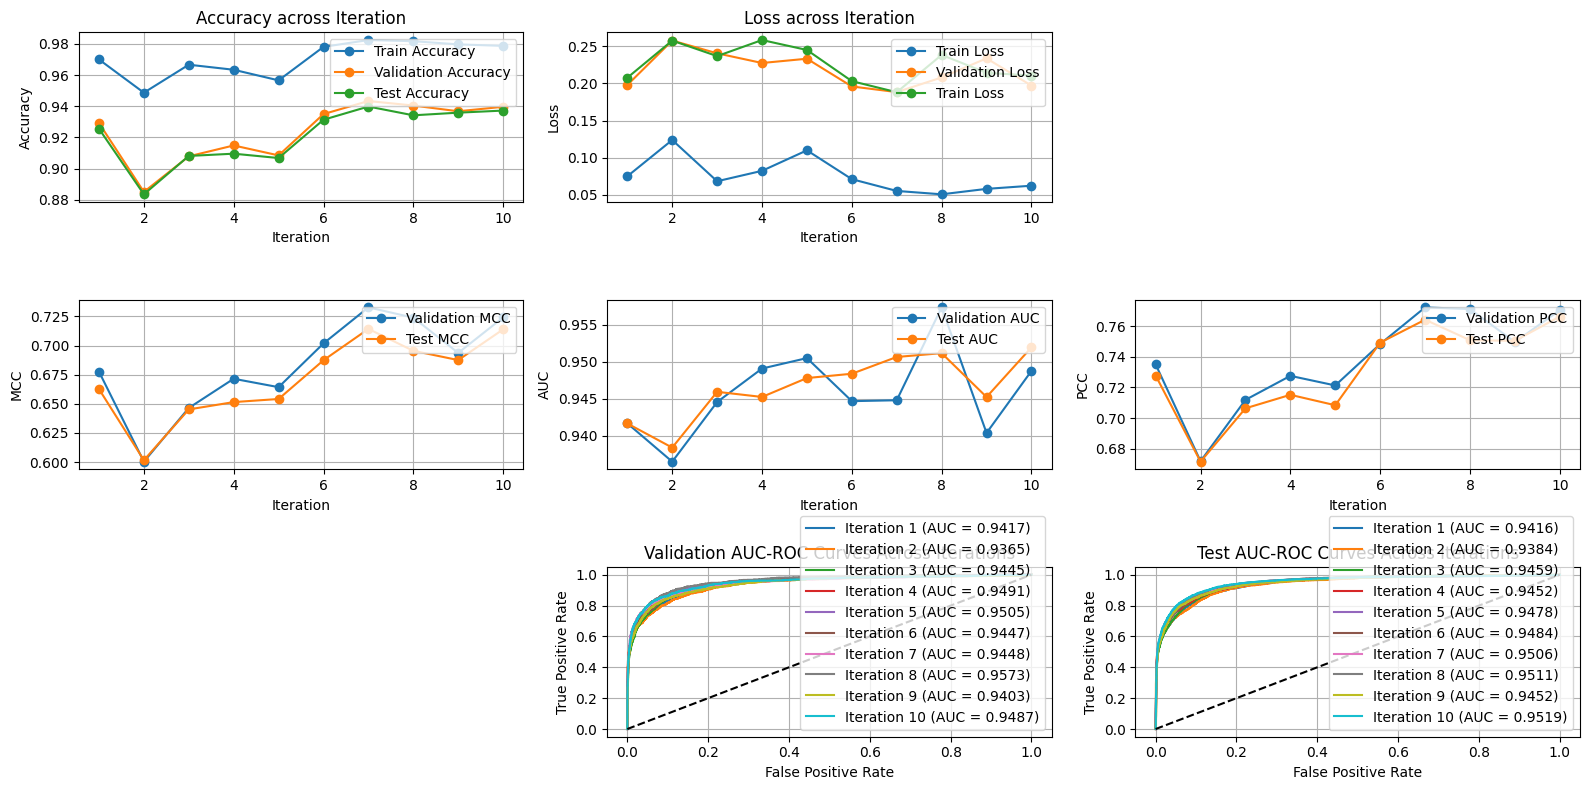

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment1.png')
plt.show()

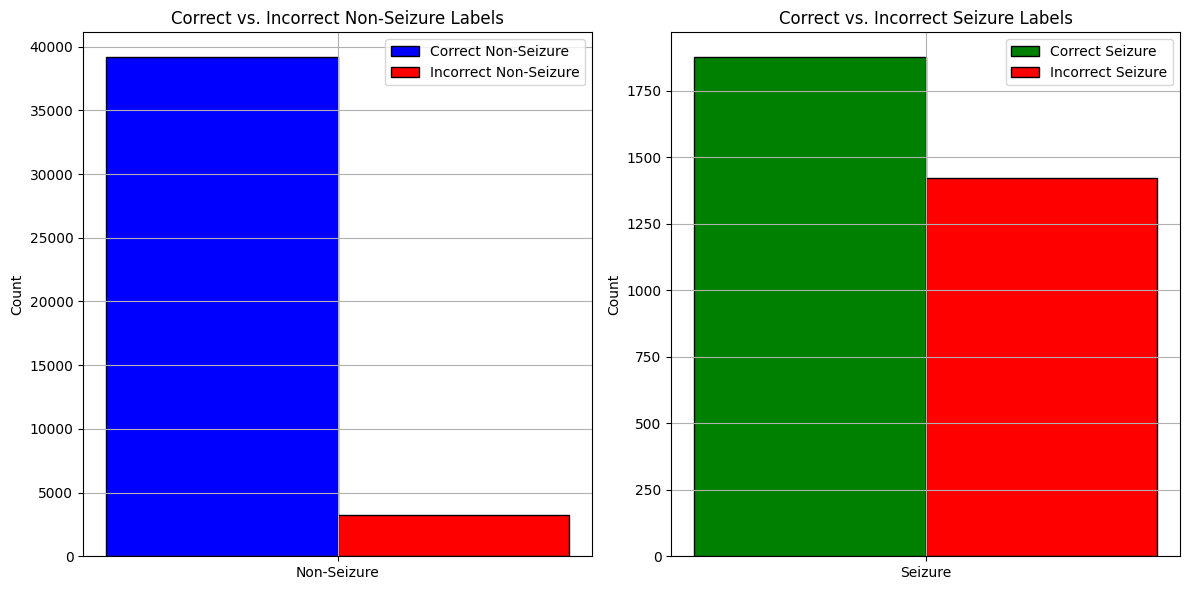

In [ ]:
#extract the indices and their corresponding pseudo labels

pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 2

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_2']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp2.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp2.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp2.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp2.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp2.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 2.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp2.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp2.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Number of confident indices: 3426
Number of confident pseudo-labelled segments = 3426 out of 50271
Percentage of confident pseudo labels = 6.82%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5791 - loss: 0.7522 - val_accuracy: 0.8691 - val_loss: 0.4762
Epoch 2/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8100 - loss: 0.4837 - val_accuracy: 0.8317 - val_loss: 0.4600
Epoch 3/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8706 - loss: 0.3868 - val_accuracy: 0.8454 - val_loss: 0.4208
Epoch 4/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8935 - loss: 0.3445 - val_accuracy: 0.9025 - val_loss: 0.3037
Epoch 5/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8998 - loss: 0.3182 - val_accuracy: 0.9164 - val_loss: 0.3027
Epoch 6/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8979 - loss: 0.2960 - val_accuracy: 0.8759 - val_loss: 0.3553
Epoch 7/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9073 - loss: 0.2860 - val_accuracy: 0.9205 - val_loss: 0.2683
Epoch 8/30
734/734 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9115 - loss: 0.2669 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5586 - loss: 0.7133 - val_accuracy: 0.8977 - val_loss: 0.3776
Epoch 2/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7998 - loss: 0.4803 - val_accuracy: 0.8901 - val_loss: 0.3552
Epoch 3/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8764 - loss: 0.3760 - val_accuracy: 0.9084 - val_loss: 0.3112
Epoch 4/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9002 - loss: 0.3331 - val_accuracy: 0.9045 - val_loss: 0.2639
Epoch 5/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8997 - loss: 0.3119 - val_accuracy: 0.9277 - val_loss: 0.2555
Epoch 6/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9117 - loss: 0.2870 - val_accuracy: 0.9251 - val_loss: 0.2300
Epoch 7/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9096 - loss: 0.2789 - val_accuracy: 0.9265 - val_loss: 0.2130
Epoch 8/30
763/763 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9156 - loss: 0.2749 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6378 - loss: 0.8042 - val_accuracy: 0.8647 - val_loss: 0.3990
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8272 - loss: 0.4380 - val_accuracy: 0.8820 - val_loss: 0.3755
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8729 - loss: 0.3551 - val_accuracy: 0.9169 - val_loss: 0.2786
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8916 - loss: 0.3247 - val_accuracy: 0.9208 - val_loss: 0.2868
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9105 - loss: 0.2956 - val_accuracy: 0.9259 - val_loss: 0.2627
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9155 - loss: 0.2731 - val_accuracy: 0.9237 - val_loss: 0.2762
Epoch 7/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9211 - loss: 0.2588 - val_accuracy: 0.9223 - val_loss: 0.2555
Epoch 8/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9210 - loss: 0.2530 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5487 - loss: 0.8202 - val_accuracy: 0.9064 - val_loss: 0.3971
Epoch 2/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8462 - loss: 0.4331 - val_accuracy: 0.9071 - val_loss: 0.3102
Epoch 3/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8927 - loss: 0.3517 - val_accuracy: 0.9139 - val_loss: 0.3021
Epoch 4/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9038 - loss: 0.3155 - val_accuracy: 0.9216 - val_loss: 0.2484
Epoch 5/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9108 - loss: 0.2915 - val_accuracy: 0.9325 - val_loss: 0.2296
Epoch 6/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9217 - loss: 0.2647 - val_accuracy: 0.9315 - val_loss: 0.2140
Epoch 7/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9209 - loss: 0.2544 - val_accuracy: 0.9129 - val_loss: 0.2507
Epoch 8/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9140 - loss: 0.2570 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4864 - loss: 0.7427 - val_accuracy: 0.8609 - val_loss: 0.4867
Epoch 2/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8136 - loss: 0.4637 - val_accuracy: 0.8617 - val_loss: 0.4397
Epoch 3/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8781 - loss: 0.3581 - val_accuracy: 0.9080 - val_loss: 0.3274
Epoch 4/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9038 - loss: 0.3066 - val_accuracy: 0.9080 - val_loss: 0.3108
Epoch 5/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9107 - loss: 0.2847 - val_accuracy: 0.9060 - val_loss: 0.3060
Epoch 6/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9155 - loss: 0.2737 - val_accuracy: 0.9245 - val_loss: 0.2398
Epoch 7/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9250 - loss: 0.2525 - val_accuracy: 0.9202 - val_loss: 0.2701
Epoch 8/30
805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9245 - loss: 0.2385 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |     0.109176 |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5511 - loss: 0.7395 - val_accuracy: 0.9027 - val_loss: 0.3713
Epoch 2/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8217 - loss: 0.4546 - val_accuracy: 0.9127 - val_loss: 0.2983
Epoch 3/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8818 - loss: 0.3541 - val_accuracy: 0.9224 - val_loss: 0.2480
Epoch 4/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8985 - loss: 0.3084 - val_accuracy: 0.9282 - val_loss: 0.2200
Epoch 5/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9134 - loss: 0.2765 - val_accuracy: 0.9316 - val_loss: 0.2189
Epoch 6/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9155 - loss: 0.2645 - val_accuracy: 0.9270 - val_loss: 0.2487
Epoch 7/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9255 - loss: 0.2485 - val_accuracy: 0.9215 - val_loss: 0.2449
Epoch 8/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9226 - loss: 0.2354 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5844 - loss: 0.8645 - val_accuracy: 0.9042 - val_loss: 0.4421
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8385 - loss: 0.4474 - val_accuracy: 0.9096 - val_loss: 0.3586
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8875 - loss: 0.3641 - val_accuracy: 0.9041 - val_loss: 0.3205
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8993 - loss: 0.3179 - val_accuracy: 0.8849 - val_loss: 0.3491
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9099 - loss: 0.2971 - val_accuracy: 0.8658 - val_loss: 0.3789
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9172 - loss: 0.2745 - val_accuracy: 0.9095 - val_loss: 0.2692
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9237 - loss: 0.2582 - val_accuracy: 0.8490 - val_loss: 0.3667
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9224 - loss: 0.2442 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6383 - loss: 0.7023 - val_accuracy: 0.9049 - val_loss: 0.3392
Epoch 2/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8484 - loss: 0.4166 - val_accuracy: 0.9266 - val_loss: 0.2460
Epoch 3/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8921 - loss: 0.3385 - val_accuracy: 0.9274 - val_loss: 0.2279
Epoch 4/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8937 - loss: 0.3148 - val_accuracy: 0.9315 - val_loss: 0.2130
Epoch 5/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9054 - loss: 0.2838 - val_accuracy: 0.9245 - val_loss: 0.2304
Epoch 6/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9125 - loss: 0.2736 - val_accuracy: 0.9280 - val_loss: 0.2122
Epoch 7/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9133 - loss: 0.2532 - val_accuracy: 0.9313 - val_loss: 0.2054
Epoch 8/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9176 - loss: 0.2398 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5305 - loss: 0.7116 - val_accuracy: 0.8808 - val_loss: 0.3987
Epoch 2/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8195 - loss: 0.4558 - val_accuracy: 0.8711 - val_loss: 0.3519
Epoch 3/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8766 - loss: 0.3591 - val_accuracy: 0.9225 - val_loss: 0.2456
Epoch 4/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8940 - loss: 0.3150 - val_accuracy: 0.9210 - val_loss: 0.2305
Epoch 5/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9035 - loss: 0.2922 - val_accuracy: 0.9279 - val_loss: 0.2215
Epoch 6/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9098 - loss: 0.2616 - val_accuracy: 0.9320 - val_loss: 0.2035
Epoch 7/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9168 - loss: 0.2444 - val_accuracy: 0.9314 - val_loss: 0.2150
Epoch 8/30
862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9209 - loss: 0.2281 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5354 - loss: 0.8920 - val_accuracy: 0.8953 - val_loss: 0.4476
Epoch 2/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7935 - loss: 0.4991 - val_accuracy: 0.9171 - val_loss: 0.3192
Epoch 3/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8594 - loss: 0.4018 - val_accuracy: 0.9243 - val_loss: 0.2730
Epoch 4/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8868 - loss: 0.3416 - val_accuracy: 0.9185 - val_loss: 0.2923
Epoch 5/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8979 - loss: 0.3112 - val_accuracy: 0.9294 - val_loss: 0.2476
Epoch 6/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9029 - loss: 0.2942 - val_accuracy: 0.9290 - val_loss: 0.2293
Epoch 7/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9088 - loss: 0.2770 - val_accuracy: 0.9160 - val_loss: 0.2737
Epoch 8/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9100 - loss: 0.2638 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                3426 |         0.959042 |    0.109176  |              0.927419 |          0.208839 |         0.741519 |         0.681091 |         0.94

Number of unlabelled samples remaining: 42273
Iteration 10 complete. Test MCC: 0.5855240388041657, Best MCC so far: 0.7235132554294607
Best model found after 10 iterations with MCC: 0.7235132554294607

aug_model_v10 saved as the best augmented model of experiment 2.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=======

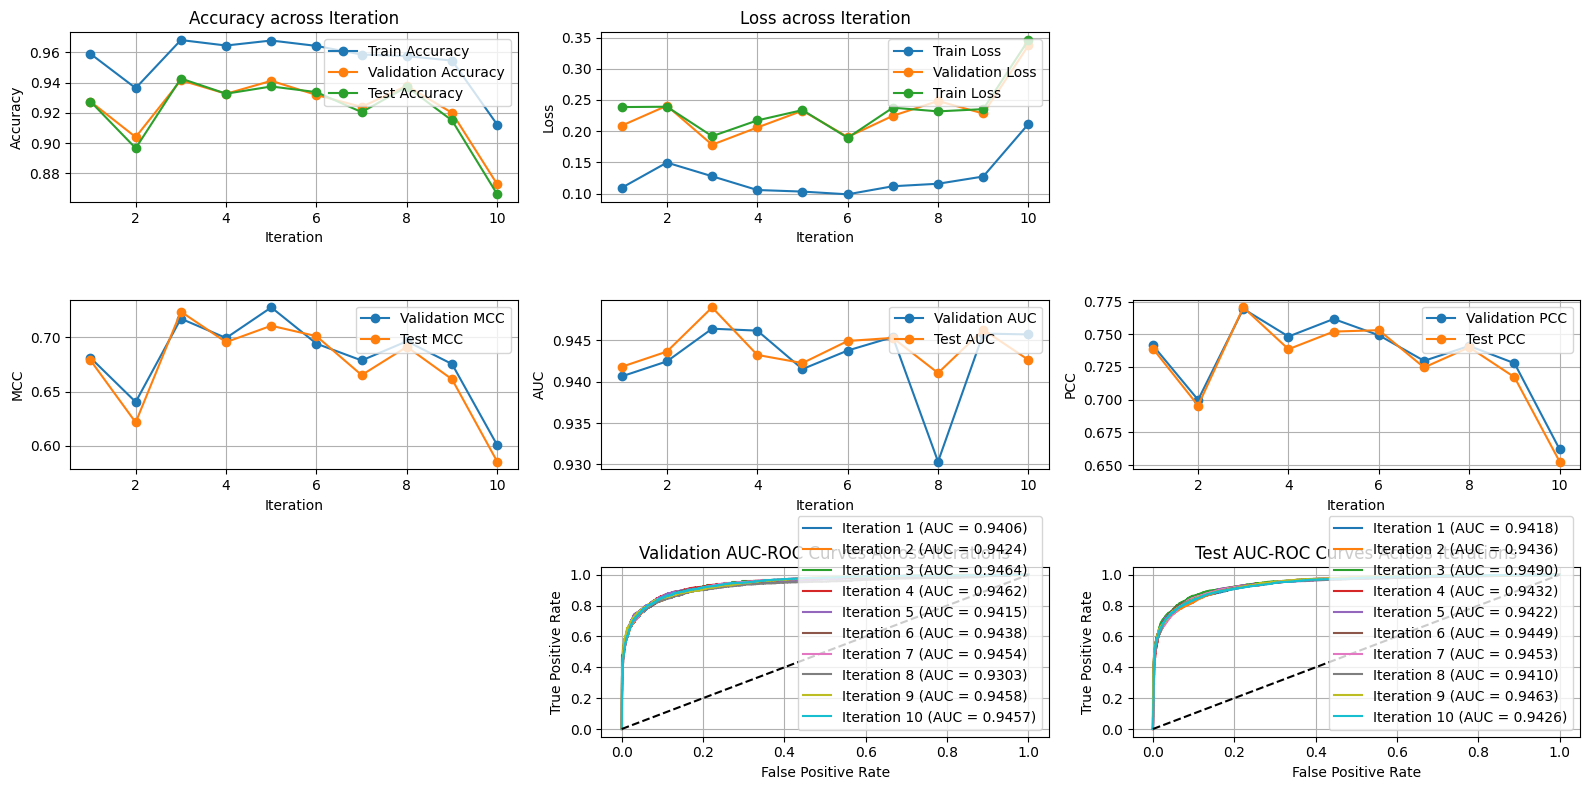

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment2.png')
plt.show()

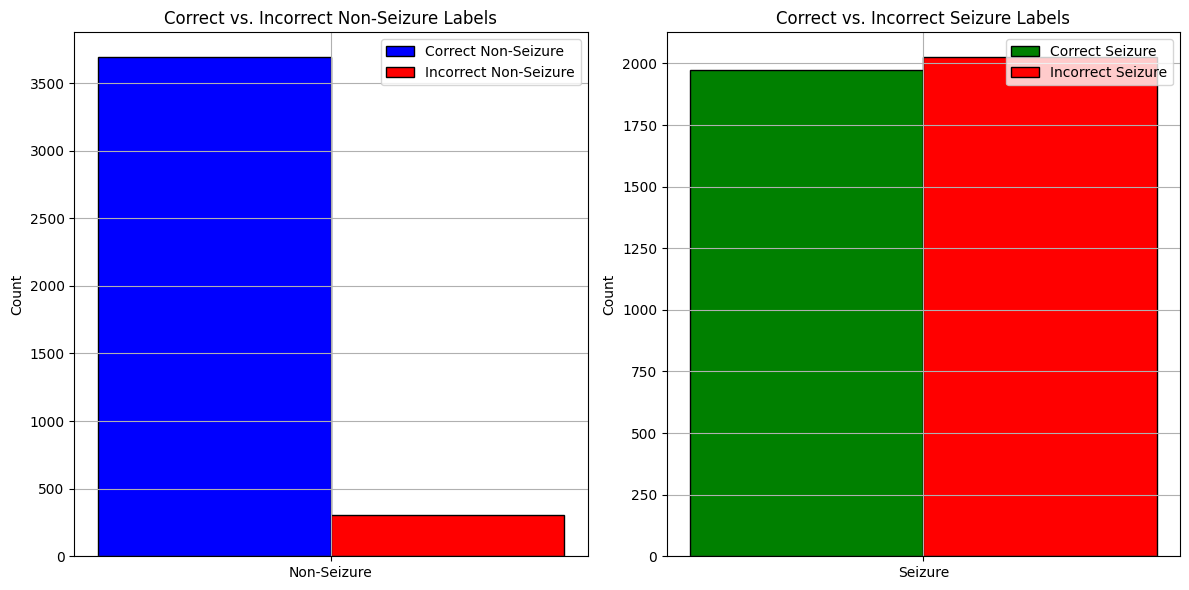

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 3

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_3']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp3.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp3.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp3.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp3.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp3.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 3.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp3.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp3.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Number of confident indices: 1713
Number of confident pseudo-labelled segments = 1713 out of 50271
Percentage of confident pseudo labels = 3.41%
Previous shape of training data: (20037, 1024, 18)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5774 - loss: 0.7732 - val_accuracy: 0.9091 - val_loss: 0.3164
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8330 - loss: 0.4476 - val_accuracy: 0.9236 - val_loss: 0.2924
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8865 - loss: 0.3712 - val_accuracy: 0.9227 - val_loss: 0.2615
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8900 - loss: 0.3309 - val_accuracy: 0.9177 - val_loss: 0.2549
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8911 - loss: 0.3067 - val_accuracy: 0.9257 - val_loss: 0.2176
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8985 - loss: 0.3002 - val_accuracy: 0.9288 - val_loss: 0.2094
Epoch 7/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9039 - loss: 0.2889 - val_accuracy: 0.9204 - val_loss: 0.2175
Epoch 8/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9074 - loss: 0.2732 - val_accuracy: 

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6051 - loss: 0.8064 - val_accuracy: 0.9063 - val_loss: 0.3692
Epoch 2/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8548 - loss: 0.4518 - val_accuracy: 0.9225 - val_loss: 0.2965
Epoch 3/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8836 - loss: 0.3944 - val_accuracy: 0.9249 - val_loss: 0.2510
Epoch 4/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9002 - loss: 0.3505 - val_accuracy: 0.9248 - val_loss: 0.2746
Epoch 5/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9016 - loss: 0.3393 - val_accuracy: 0.9284 - val_loss: 0.2662
Epoch 6/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9078 - loss: 0.3065 - val_accuracy: 0.9262 - val_loss: 0.2406
Epoch 7/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9046 - loss: 0.2997 - val_accuracy: 0.9155 - val_loss: 0.2781
Epoch 8/30
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9132 - loss: 0.2862 - val_accuracy: 

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5843 - loss: 0.7746 - val_accuracy: 0.8441 - val_loss: 0.5250
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8397 - loss: 0.4312 - val_accuracy: 0.9203 - val_loss: 0.3105
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8952 - loss: 0.3584 - val_accuracy: 0.9205 - val_loss: 0.3083
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9075 - loss: 0.3064 - val_accuracy: 0.9256 - val_loss: 0.3141
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9141 - loss: 0.2913 - val_accuracy: 0.9220 - val_loss: 0.2668
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9167 - loss: 0.2781 - val_accuracy: 0.9296 - val_loss: 0.2250
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9181 - loss: 0.2670 - val_accuracy: 0.9325 - val_loss: 0.2115
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9182 - loss: 0.2443 - val_accuracy: 

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6232 - loss: 0.7281 - val_accuracy: 0.9000 - val_loss: 0.3525
Epoch 2/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8281 - loss: 0.4681 - val_accuracy: 0.9103 - val_loss: 0.3098
Epoch 3/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8739 - loss: 0.3832 - val_accuracy: 0.9230 - val_loss: 0.2800
Epoch 4/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8845 - loss: 0.3549 - val_accuracy: 0.9159 - val_loss: 0.2724
Epoch 5/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8914 - loss: 0.3405 - val_accuracy: 0.9237 - val_loss: 0.2484
Epoch 6/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8968 - loss: 0.3073 - val_accuracy: 0.8967 - val_loss: 0.3478
Epoch 7/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9054 - loss: 0.2859 - val_accuracy: 0.9103 - val_loss: 0.2759
Epoch 8/30
711/711 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9015 - loss: 0.2820 - val_accuracy: 

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5723 - loss: 0.7034 - val_accuracy: 0.9030 - val_loss: 0.3545
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8503 - loss: 0.4395 - val_accuracy: 0.9078 - val_loss: 0.3005
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8720 - loss: 0.3666 - val_accuracy: 0.9029 - val_loss: 0.3067
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8966 - loss: 0.3265 - val_accuracy: 0.9231 - val_loss: 0.2489
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9050 - loss: 0.3021 - val_accuracy: 0.9266 - val_loss: 0.2546
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8976 - loss: 0.2921 - val_accuracy: 0.9197 - val_loss: 0.2678
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9110 - loss: 0.2617 - val_accuracy: 0.9230 - val_loss: 0.2375
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9171 - loss: 0.2538 - val_accuracy: 

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.5796 - loss: 0.6852 - val_accuracy: 0.8790 - val_loss: 0.4135
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8384 - loss: 0.4319 - val_accuracy: 0.9112 - val_loss: 0.3447
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8789 - loss: 0.3599 - val_accuracy: 0.9183 - val_loss: 0.3005
Epoch 4/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8925 - loss: 0.3217 - val_accuracy: 0.8794 - val_loss: 0.3556
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8986 - loss: 0.3012 - val_accuracy: 0.9225 - val_loss: 0.2420
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9079 - loss: 0.2772 - val_accuracy: 0.9287 - val_loss: 0.2562
Epoch 7/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9172 - loss: 0.2603 - val_accuracy: 0.8307 - val_loss: 0.4006
Epoch 8/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9134 - loss: 0.2504 - val_accuracy: 

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5597 - loss: 0.7231 - val_accuracy: 0.9021 - val_loss: 0.3906
Epoch 2/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8454 - loss: 0.4327 - val_accuracy: 0.9176 - val_loss: 0.3136
Epoch 3/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8840 - loss: 0.3664 - val_accuracy: 0.9094 - val_loss: 0.2937
Epoch 4/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9014 - loss: 0.3217 - val_accuracy: 0.9287 - val_loss: 0.2191
Epoch 5/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9120 - loss: 0.2981 - val_accuracy: 0.9304 - val_loss: 0.2162
Epoch 6/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9189 - loss: 0.2761 - val_accuracy: 0.9294 - val_loss: 0.2146
Epoch 7/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9187 - loss: 0.2637 - val_accuracy: 0.9347 - val_loss: 0.1973
Epoch 8/30
728/728 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9215 - loss: 0.2605 - val_accuracy: 

Performance metrics for iteration 7:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5496 - loss: 0.7732 - val_accuracy: 0.9072 - val_loss: 0.3826
Epoch 2/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8497 - loss: 0.4127 - val_accuracy: 0.9252 - val_loss: 0.2411
Epoch 3/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8958 - loss: 0.3330 - val_accuracy: 0.9294 - val_loss: 0.2226
Epoch 4/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9038 - loss: 0.3045 - val_accuracy: 0.9156 - val_loss: 0.2615
Epoch 5/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9124 - loss: 0.2922 - val_accuracy: 0.9336 - val_loss: 0.2097
Epoch 6/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9183 - loss: 0.2642 - val_accuracy: 0.9231 - val_loss: 0.2256
Epoch 7/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9227 - loss: 0.2518 - val_accuracy: 0.9358 - val_loss: 0.1927
Epoch 8/30
729/729 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9266 - loss: 0.2363 - val_accuracy: 

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5755 - loss: 0.8151 - val_accuracy: 0.8824 - val_loss: 0.4124
Epoch 2/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7700 - loss: 0.5202 - val_accuracy: 0.9127 - val_loss: 0.3019
Epoch 3/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8613 - loss: 0.3896 - val_accuracy: 0.9255 - val_loss: 0.2795
Epoch 4/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8875 - loss: 0.3379 - val_accuracy: 0.9268 - val_loss: 0.2688
Epoch 5/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8968 - loss: 0.3145 - val_accuracy: 0.9257 - val_loss: 0.2490
Epoch 6/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9046 - loss: 0.2954 - val_accuracy: 0.9228 - val_loss: 0.2759
Epoch 7/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9085 - loss: 0.2808 - val_accuracy: 0.9328 - val_loss: 0.2368
Epoch 8/30
731/731 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9156 - loss: 0.2561 - val_accuracy: 

Performance metrics for iteration 9:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.945

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4839 - loss: 0.7726 - val_accuracy: 0.8939 - val_loss: 0.4000
Epoch 2/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7676 - loss: 0.5197 - val_accuracy: 0.9146 - val_loss: 0.3092
Epoch 3/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8678 - loss: 0.3830 - val_accuracy: 0.9284 - val_loss: 0.2775
Epoch 4/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8972 - loss: 0.3209 - val_accuracy: 0.9125 - val_loss: 0.2975
Epoch 5/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9022 - loss: 0.2987 - val_accuracy: 0.9318 - val_loss: 0.2266
Epoch 6/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9054 - loss: 0.2863 - val_accuracy: 0.9343 - val_loss: 0.2031
Epoch 7/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9130 - loss: 0.2622 - val_accuracy: 0.9326 - val_loss: 0.1975
Epoch 8/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9172 - loss: 0.2459 - val_accuracy: 

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                                1713 |         0.953057 |     0.140156 |              0.938769 |          0.256772 |         0.746763 |         0.696994 |         0.94

Number of unlabelled samples remaining: 46906
Iteration 10 complete. Test MCC: 0.67754023724436, Best MCC so far: 0.709280227495074
Best model found after 10 iterations with MCC: 0.709280227495074

aug_model_v10 saved as the best augmented model of experiment 3.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+===========

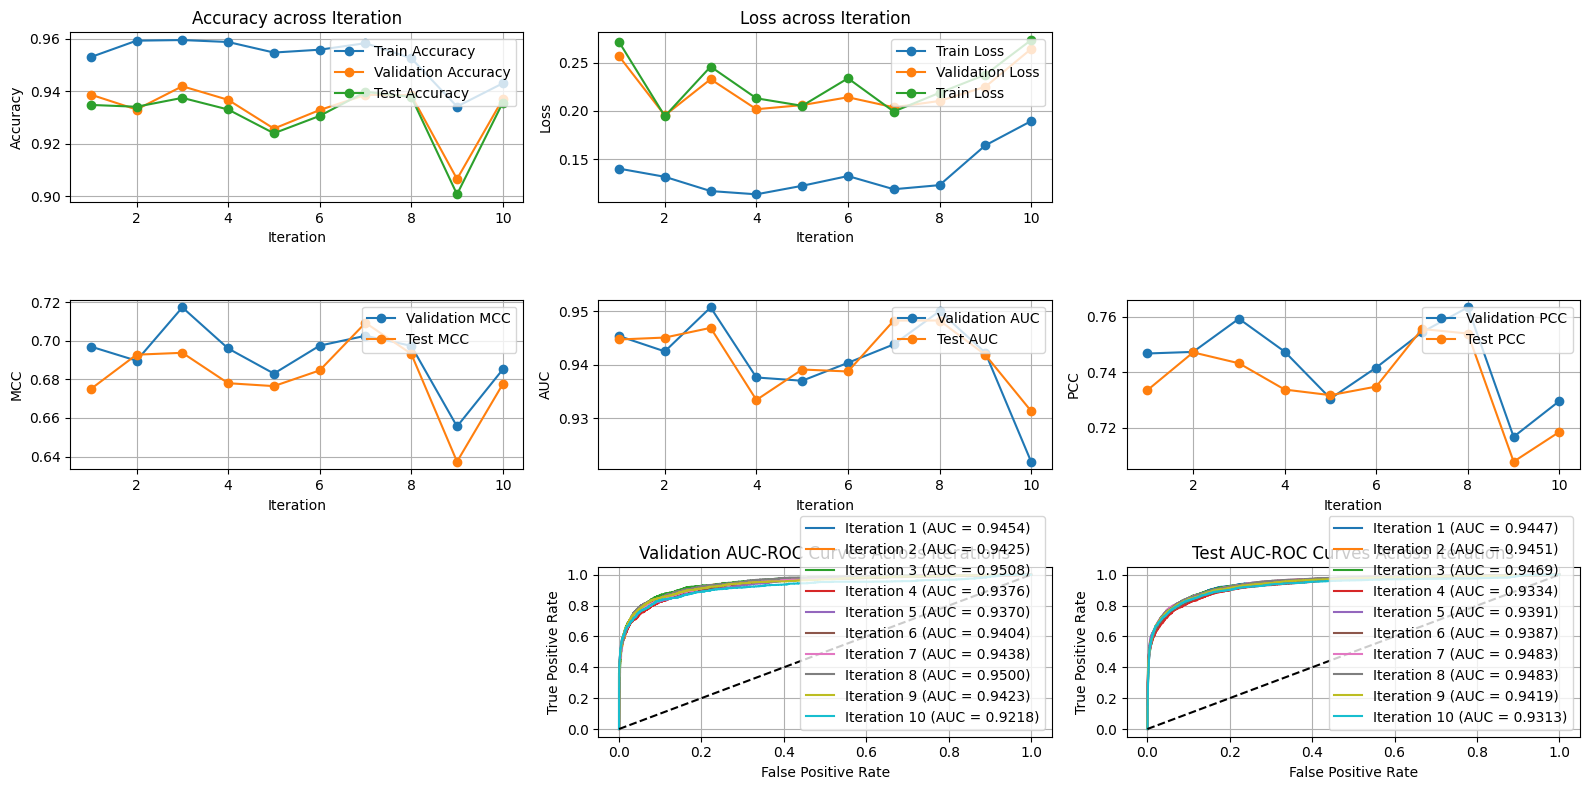

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment3.png')
plt.show()

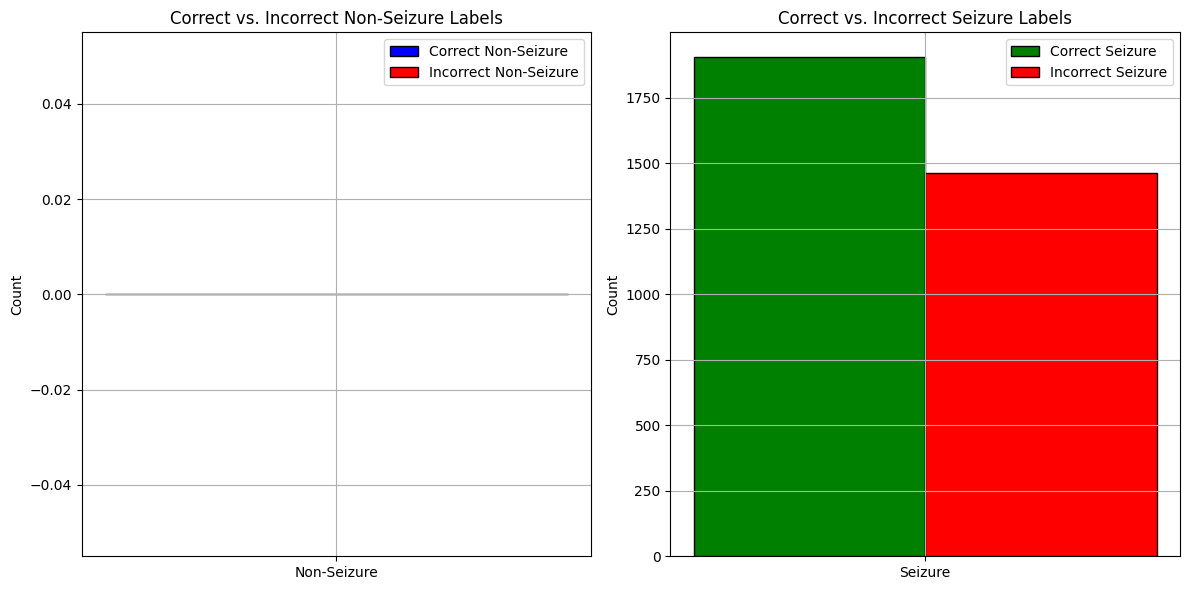

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Experiment 4

In [ ]:
iter_base_model = base_model
unlabelled_data = x_train_unseg
augmented_model_v = {}
metrics_df = {}
pseudo_labelled_segdf = {}
augmented_segments = np.array([]).reshape(0, x_train_lseg.shape[1], x_train_lseg.shape[2])
augmented_labels = np.array([])

#main loop for running through multiple iterations
for i in range(1, num_iterations + 1):

    print(f"\nIteration {i}")

    #select pseudo-labeling parameters for the experiment
    exp_params = experiments['exp_4']

    #pseudo-labeling on the current unlabelled set
    conf_indices, conf_segments, conf_labels, conf_values = pseudo_labeling(i, iter_base_model,
                                                                            unlabelled_data,
                                                                            conf_thresh=exp_params['conf_thresh'],
                                                                            fixed_percentage=exp_params['fixed_percentage'],
                                                                            add_both=exp_params['add_both'],
                                                                            equal=exp_params['equal'],
                                                                            seizure_only=exp_params['seizure_only'],
                                                                            nonseizure_only=exp_params['nonseizure_only'])

    print(f"\nNumber of confident indices: {len(conf_indices)}")

    #print the stats
    num_conf_segments = conf_segments.shape[0]
    percentage_conf_segments = (num_conf_segments / x_train_unseg.shape[0]) * 100
    print(f"Number of confident pseudo-labelled segments = {num_conf_segments} out of {unlabelled_data.shape[0]}")
    print(f"Percentage of confident pseudo labels = {percentage_conf_segments:.2f}%")

    #overwrite or append new pseudo-labels to the pseudo_labelled_segments table
    pseudo_labelled_segments = overwrite_pseudo_labels(conf_indices,
                                                       conf_labels,
                                                       conf_values,
                                                       pseudo_labelled_segments,
                                                       reclassify=exp_params['reclassify'])

    if i == 1:
        print(f"Previous shape of training data: {x_train_lseg.shape}")
    else:
        print(f"Previous shape of training data: {augmented_segments.shape}")

    #retrain the model using the newly pseudo-labeled data (augmented model)
    augmented_model_v[i], augmented_segments, augmented_labels = retrain_model(i,
                                                                               #augmented_model_v.get(i,iter_base_model),
                                                                               None,
                                                                               x_train_lseg,
                                                                               y_train_labels,
                                                                               conf_segments,
                                                                               conf_labels,
                                                                               augmented_segments,
                                                                               augmented_labels,
                                                                               #iter_base_model,
                                                                               None,
                                                                               val_seg,
                                                                               val_labels,
                                                                               reclassify=exp_params['reclassify'])

    print(f"Current shape of training data after adding pseudo-labels: {augmented_segments.shape}")

    #evaluate the newly trained model and store metrics for this iteration
    metrics_history, val_roc_curves, test_roc_curves = evaluate_model(conf_indices,
                                                                      augmented_model_v[i],
                                                                      augmented_segments,
                                                                      augmented_labels,
                                                                      val_seg, val_labels,
                                                                      test_seg, test_labels,
                                                                      metrics_history,
                                                                      val_roc_curves, test_roc_curves,
                                                                      i)

    print(f"Performance metrics for iteration {i}:")
    print(tabulate(metrics_history, headers='keys', tablefmt='grid', showindex=False))

    #update the base model for the next iteration, using the current augmented model
    iter_base_model = augmented_model_v[i]

    #check if current model is better than previous models based on test MCC
    current_mcc = metrics_history['Test MCC'][-1]
    if current_mcc > best_mcc:
        best_mcc = current_mcc
        best_augmented_model = augmented_model_v[i]
        best_augmented_model.save('Best_current_AugModel_Exp4.h5')
        print(f"New best model found at iteration {i} with MCC: {best_mcc}")

    #save the augmented model
    augmented_model_v[i].save(f'AugModel_v{i}_Exp4.h5')
    print(f'\naugmented_model_v{i} saved for iteration {i}.')

    #save the updated metrics to csv
    metrics_df[i] = pd.DataFrame(metrics_history)
    metrics_df[i].to_csv(f'Performance_Metrics_v{i}_Exp4.csv', index = False)

    #save the updated pseudo labelled data
    pseudo_labelled_segdf[i] = pd.DataFrame(pseudo_labelled_segments)
    pseudo_labelled_segdf[i].to_csv(f'Pseudo_Labels_v{i}_Exp4.csv', index = False)

    #if not reclassifying, remove the pseudo-labeled segments from the unlabelled set
    if exp_params['reclassify'] == False:

        unlabelled_data = np.delete(unlabelled_data, conf_indices, axis=0)
        print(f"Number of unlabelled samples remaining: {unlabelled_data.shape[0]}")

    print(f"Iteration {i} complete. Test MCC: {current_mcc}, Best MCC so far: {best_mcc}")

#final best model after all iterations
print(f"Best model found after {num_iterations} iterations with MCC: {best_mcc}")

#save the final best augmented model
best_augmented_model.save('Best_AugModel_Exp4.h5')
print(f'\naug_model_v{i} saved as the best augmented model of experiment 4.')

#save the final metrics to csv
metrics_df = pd.DataFrame(metrics_history)
metrics_df.to_csv('Performance_Metrics_Exp4.csv', index = False)

#print the table
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

#save the final pseudo labelled data
pseudo_labelled_segdf = pd.DataFrame(pseudo_labelled_segments)
pseudo_labelled_segdf.to_csv('Pseudo_Labels_Exp4.csv', index = False)



Iteration 1
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step

Number of confident indices: 18082
Number of confident pseudo-labelled segments = 18082 out of 50271
Percentage of confident pseudo labels = 35.97%
Previous shape of training data: (20037, 1024, 18)


C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.5281 - loss: 0.8177 - val_accuracy: 0.6273 - val_loss: 0.6578
Epoch 2/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.6757 - loss: 0.5989 - val_accuracy: 0.7558 - val_loss: 0.6017
Epoch 3/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8099 - loss: 0.5253 - val_accuracy: 0.8129 - val_loss: 0.5067
Epoch 4/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8336 - loss: 0.4395 - val_accuracy: 0.8437 - val_loss: 0.4223
Epoch 5/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8531 - loss: 0.3856 - val_accuracy: 0.6682 - val_loss: 0.5880
Epoch 6/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - accuracy: 0.8593 - loss: 0.3701 - val_accuracy: 0.8523 - val_loss: 0.3762
Epoch 7/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8686 - loss: 0.3356 - val_accuracy: 0.8542 - val_loss: 0.3647
Epoch 8/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.8713 -

Performance metrics for iteration 1:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |           0.27505 |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 60s 37ms/step - accuracy: 0.4912 - loss: 0.7327 - val_accuracy: 0.7324 - val_loss: 0.6365
Epoch 2/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.6826 - loss: 0.6159 - val_accuracy: 0.8292 - val_loss: 0.4657
Epoch 3/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.7896 - loss: 0.5377 - val_accuracy: 0.8903 - val_loss: 0.3723
Epoch 4/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8269 - loss: 0.4576 - val_accuracy: 0.8472 - val_loss: 0.4234
Epoch 5/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8306 - loss: 0.4068 - val_accuracy: 0.7735 - val_loss: 0.4995
Epoch 6/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8400 - loss: 0.3951 - val_accuracy: 0.6998 - val_loss: 0.5708
Epoch 7/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.8411 - loss: 0.3955 - val_accuracy: 0.8033 - val_loss: 0.4657
Epoch 8/30
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8633 -

Performance metrics for iteration 2:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.5541 - loss: 0.8224 - val_accuracy: 0.7944 - val_loss: 0.5617
Epoch 2/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - accuracy: 0.7847 - loss: 0.5194 - val_accuracy: 0.8636 - val_loss: 0.3818
Epoch 3/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8292 - loss: 0.4507 - val_accuracy: 0.8379 - val_loss: 0.4115
Epoch 4/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8599 - loss: 0.3936 - val_accuracy: 0.8428 - val_loss: 0.4021
Epoch 5/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8772 - loss: 0.3540 - val_accuracy: 0.8588 - val_loss: 0.3711
Epoch 6/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8781 - loss: 0.3291 - val_accuracy: 0.8771 - val_loss: 0.2869
Epoch 7/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8824 - loss: 0.3057 - val_accuracy: 0.8466 - val_loss: 0.3664
Epoch 8/30
1623/1623 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8818 -

Performance metrics for iteration 3:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 66s 36ms/step - accuracy: 0.5421 - loss: 0.8184 - val_accuracy: 0.7172 - val_loss: 0.6531
Epoch 2/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8072 - loss: 0.5891 - val_accuracy: 0.8283 - val_loss: 0.5211
Epoch 3/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8422 - loss: 0.4956 - val_accuracy: 0.8642 - val_loss: 0.4295
Epoch 4/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8472 - loss: 0.4481 - val_accuracy: 0.8819 - val_loss: 0.3738
Epoch 5/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8595 - loss: 0.4046 - val_accuracy: 0.8872 - val_loss: 0.3166
Epoch 6/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8755 - loss: 0.3771 - val_accuracy: 0.8791 - val_loss: 0.3192
Epoch 7/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.8784 - loss: 0.3704 - val_accuracy: 0.9024 - val_loss: 0.2713
Epoch 8/30
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - accuracy: 0.8843 -

Performance metrics for iteration 4:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.5516 - loss: 0.7322 - val_accuracy: 0.6207 - val_loss: 0.7079
Epoch 2/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.7818 - loss: 0.5783 - val_accuracy: 0.7198 - val_loss: 0.6115
Epoch 3/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8525 - loss: 0.4550 - val_accuracy: 0.8051 - val_loss: 0.4767
Epoch 4/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 56s 33ms/step - accuracy: 0.8536 - loss: 0.4108 - val_accuracy: 0.7398 - val_loss: 0.5519
Epoch 5/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 57s 34ms/step - accuracy: 0.8646 - loss: 0.3793 - val_accuracy: 0.7890 - val_loss: 0.5013
Epoch 6/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8619 - loss: 0.3696 - val_accuracy: 0.8484 - val_loss: 0.3490
Epoch 7/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8801 - loss: 0.3276 - val_accuracy: 0.8919 - val_loss: 0.2963
Epoch 8/30
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.8884 -

Performance metrics for iteration 5:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 68s 37ms/step - accuracy: 0.4617 - loss: 0.7506 - val_accuracy: 0.6536 - val_loss: 0.6594
Epoch 2/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.7628 - loss: 0.6167 - val_accuracy: 0.8791 - val_loss: 0.5007
Epoch 3/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.8339 - loss: 0.5295 - val_accuracy: 0.8790 - val_loss: 0.4250
Epoch 4/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8337 - loss: 0.4747 - val_accuracy: 0.8537 - val_loss: 0.4695
Epoch 5/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8481 - loss: 0.4481 - val_accuracy: 0.8363 - val_loss: 0.4646
Epoch 6/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8540 - loss: 0.4378 - val_accuracy: 0.8746 - val_loss: 0.3913
Epoch 7/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8809 - loss: 0.3813 - val_accuracy: 0.8896 - val_loss: 0.3353
Epoch 8/30
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.8782 -

Performance metrics for iteration 6:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - accuracy: 0.5491 - loss: 0.8595 - val_accuracy: 0.7574 - val_loss: 0.6075
Epoch 2/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7945 - loss: 0.5373 - val_accuracy: 0.8484 - val_loss: 0.4456
Epoch 3/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.8396 - loss: 0.4668 - val_accuracy: 0.8558 - val_loss: 0.3626
Epoch 4/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.8185 - loss: 0.4533 - val_accuracy: 0.8803 - val_loss: 0.3415
Epoch 5/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.8619 - loss: 0.3987 - val_accuracy: 0.8763 - val_loss: 0.3179
Epoch 6/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.8737 - loss: 0.3781 - val_accuracy: 0.8994 - val_loss: 0.2914
Epoch 7/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8768 - loss: 0.3418 - val_accuracy: 0.8479 - val_loss: 0.3618
Epoch 8/30
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8684 -

+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929505 |        0.890288 |    0.27707  |

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.6166 - loss: 0.7126 - val_accuracy: 0.8583 - val_loss: 0.5570
Epoch 2/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8444 - loss: 0.5126 - val_accuracy: 0.8527 - val_loss: 0.4627
Epoch 3/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8629 - loss: 0.4376 - val_accuracy: 0.9116 - val_loss: 0.3253
Epoch 4/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8569 - loss: 0.3998 - val_accuracy: 0.8826 - val_loss: 0.3644
Epoch 5/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8809 - loss: 0.3520 - val_accuracy: 0.8748 - val_loss: 0.3806
Epoch 6/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8834 - loss: 0.3400 - val_accuracy: 0.9098 - val_loss: 0.2986
Epoch 7/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8867 - loss: 0.3145 - val_accuracy: 0.8985 - val_loss: 0.2655
Epoch 8/30
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8823 -

Performance metrics for iteration 8:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.5269 - loss: 0.7244 - val_accuracy: 0.6779 - val_loss: 0.6366
Epoch 2/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.7707 - loss: 0.5386 - val_accuracy: 0.8710 - val_loss: 0.4225
Epoch 3/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.8318 - loss: 0.4518 - val_accuracy: 0.8771 - val_loss: 0.3457
Epoch 4/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.8469 - loss: 0.4099 - val_accuracy: 0.9087 - val_loss: 0.2939
Epoch 5/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8502 - loss: 0.4008 - val_accuracy: 0.8975 - val_loss: 0.2669
Epoch 6/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8574 - loss: 0.3622 - val_accuracy: 0.8634 - val_loss: 0.3253
Epoch 7/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8673 - loss: 0.3345 - val_accuracy: 0.8854 - val_loss: 0.2886
Epoch 8/30
1808/1808 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.8846 -

+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.929505 |        0.890288 |    0.27707  |

C:\Users\123100025\tfvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - accuracy: 0.5095 - loss: 0.8789 - val_accuracy: 0.6981 - val_loss: 0.6522
Epoch 2/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 36ms/step - accuracy: 0.7178 - loss: 0.5927 - val_accuracy: 0.8467 - val_loss: 0.4883
Epoch 3/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8443 - loss: 0.4935 - val_accuracy: 0.8954 - val_loss: 0.3896
Epoch 4/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.8393 - loss: 0.4549 - val_accuracy: 0.9074 - val_loss: 0.3122
Epoch 5/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8526 - loss: 0.4212 - val_accuracy: 0.8880 - val_loss: 0.3130
Epoch 6/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 64s 35ms/step - accuracy: 0.8752 - loss: 0.3891 - val_accuracy: 0.8800 - val_loss: 0.3409
Epoch 7/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8764 - loss: 0.3634 - val_accuracy: 0.9025 - val_loss: 0.2944
Epoch 8/30
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 65s 35ms/step - accuracy: 0.8740 -

Performance metrics for iteration 10:
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=============+============+============+============+
|           1 |                               18082 |         0.952963 |     0.106128 |              0.890283 |          0.27505  |         0.669415 |         0.605679 |         0.92

Number of unlabelled samples remaining: 11609
Iteration 10 complete. Test MCC: 0.6176649391359522, Best MCC so far: 0.6176649391359522
Best model found after 10 iterations with MCC: 0.6176649391359522

aug_model_v10 saved as the best augmented model of experiment 4.
+-------------+-------------------------------------+------------------+--------------+-----------------------+-------------------+------------------+------------------+------------------+-----------------+-------------+------------+------------+------------+
|   Iteration |   Number of Confident Indices Added |   Train Accuracy |   Train Loss |   Validation Accuracy |   Validation Loss |   Validation PCC |   Validation MCC |   Validation AUC |   Test Accuracy |   Test Loss |   Test PCC |   Test MCC |   Test AUC |
+=============+=====================================+==================+==============+=======================+===================+==================+==================+==================+=================+=======

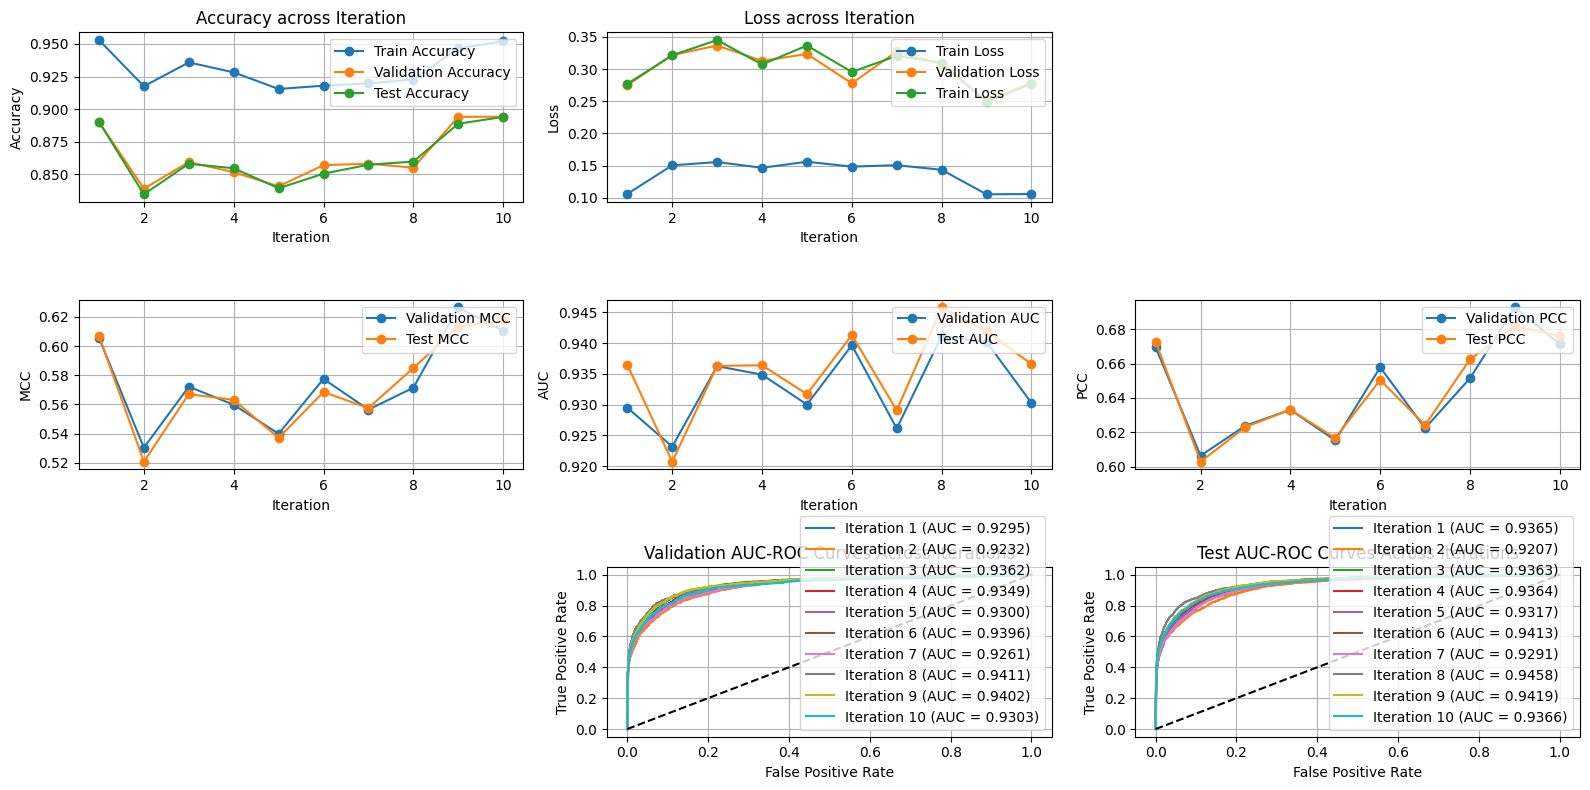

In [ ]:
#plots

plt.figure(figsize=(16, 8))

#accuracy
plt.subplot(3,3,1)
plt.plot(metrics_df['Iteration'], metrics_df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Accuracy'], label='Test Accuracy', marker='o')
plt.title('Accuracy across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc = 'upper right')
plt.grid(True)

#loss
plt.subplot(3,3,2)
plt.plot(metrics_df['Iteration'], metrics_df['Train Loss'], label='Train Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Validation Loss'], label='Validation Loss', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test Loss'], label='Train Loss', marker='o')
plt.title('Loss across Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 4)
plt.plot(metrics_df['Iteration'], metrics_df['Validation MCC'], label='Validation MCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test MCC'], label='Test MCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('MCC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 5)
plt.plot(metrics_df['Iteration'], metrics_df['Validation AUC'], label='Validation AUC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test AUC'], label='Test AUC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(3, 3, 6)
plt.plot(metrics_df['Iteration'], metrics_df['Validation PCC'], label='Validation PCC', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Test PCC'], label='Test PCC', marker='o')
plt.xlabel('Iteration')
plt.ylabel('PCC')
plt.legend(loc = 'upper right')
plt.grid(True)

'''plt.subplot(3, 3, 7)
plt.plot(metrics_df['Iteration'], metrics_df['Number of Confident Indices Added'], label='Confident Pseudo Labels', marker='o')
plt.plot(metrics_df['Iteration'], metrics_df['Number of Correct Labels'], label='Correct Labels', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Labels')
plt.legend(loc = 'upper right')
plt.grid(True)'''

plt.subplot(3, 3, 8)
for i in range(1, num_iterations + 1):

    plt.plot(val_roc_curves['fpr'][i-1], val_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {val_roc_curves["val_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Validation AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(3, 3, 9)
for i in range(1, num_iterations + 1):

    plt.plot(test_roc_curves['fpr'][i-1], test_roc_curves['tpr'][i-1],
             label=f'Iteration {i} (AUC = {test_roc_curves["test_auc"][i-1]:.4f})')

# Plot the diagonal line representing random guess
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Customize plot labels and title
plt.title('Test AUC-ROC Curves Across Iterations')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.savefig('Performance_Plot_Experiment4.png')
plt.show()

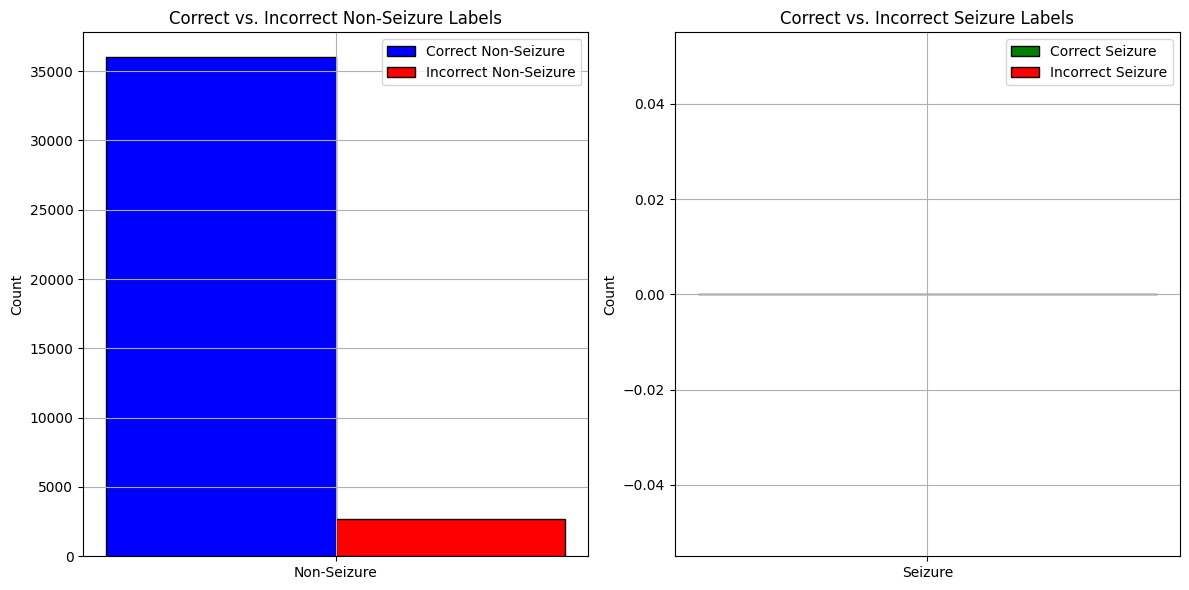

In [ ]:
#extract the indices and their corresponding pseudo labels
pseudo_indices = np.array(pseudo_labelled_segments['Indices'])
pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

#corresponding actual labels
actual_labels = y_train_unlabels[pseudo_indices]

#count the correct and incorrect labels for both seizure and non-seizure
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))
    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))
    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


#counts of correct and incorrect labels for seizure and non-seizure
correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure = count_labels(pseudo_labels, actual_labels)

#plot
bw = 0.35
index = np.arange(2)

plt.figure(figsize=(12, 6))

#correct and incorrect non-seizure labels
plt.subplot(1, 2, 1)
plt.bar(index[0] - bw/2, correct_nonseizure, bw, color='blue', edgecolor='black', label='Correct Non-Seizure')
plt.bar(index[0] + bw/2, incorrect_nonseizure, bw, color='red', edgecolor='black', label='Incorrect Non-Seizure')

plt.xticks(index[:1], ['Non-Seizure'])
plt.title('Correct vs. Incorrect Non-Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

# Correct and Incorrect for Seizure
plt.subplot(1, 2, 2)
plt.bar(index[1] - bw/2, correct_seizure, bw, color='green', edgecolor='black', label='Correct Seizure')
plt.bar(index[1] + bw/2, incorrect_seizure, bw, color='red', edgecolor='black', label='Incorrect Seizure')

plt.xticks(index[1:], ['Seizure'])
plt.title('Correct vs. Incorrect Seizure Labels')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison Between The Experiments

In [22]:
#load the models

base_model = tf.keras.models.load_model('base_model.h5')
ideal_model = tf.keras.models.load_model('ideal_model.h5')

aug_model = {}

#loading the final iteration model instead of the best model
for i in range(1, 5):

    aug_model[i] = tf.keras.models.load_model(f'AugModel_v10_Exp{i}.h5')


Evaluation of Base Model
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8895 - loss: 0.2637
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Ideal Model
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9439 - loss: 0.1573
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 1 - Conf Thresh, Unequal Segments, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9362 - loss: 0.1978
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 2 - Conf Thresh, Equal Segments, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8677 - loss: 0.3283
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 3 - Conf Thresh, Seizure Segments, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9358 - loss: 0.2728
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Evaluation of Exp 4 - Conf Thresh, Non-Seizure Segments, no reclass
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8967 - loss: 0.2757
628/628 ━━━━━━━━━━━━━━━━━━━━ 3

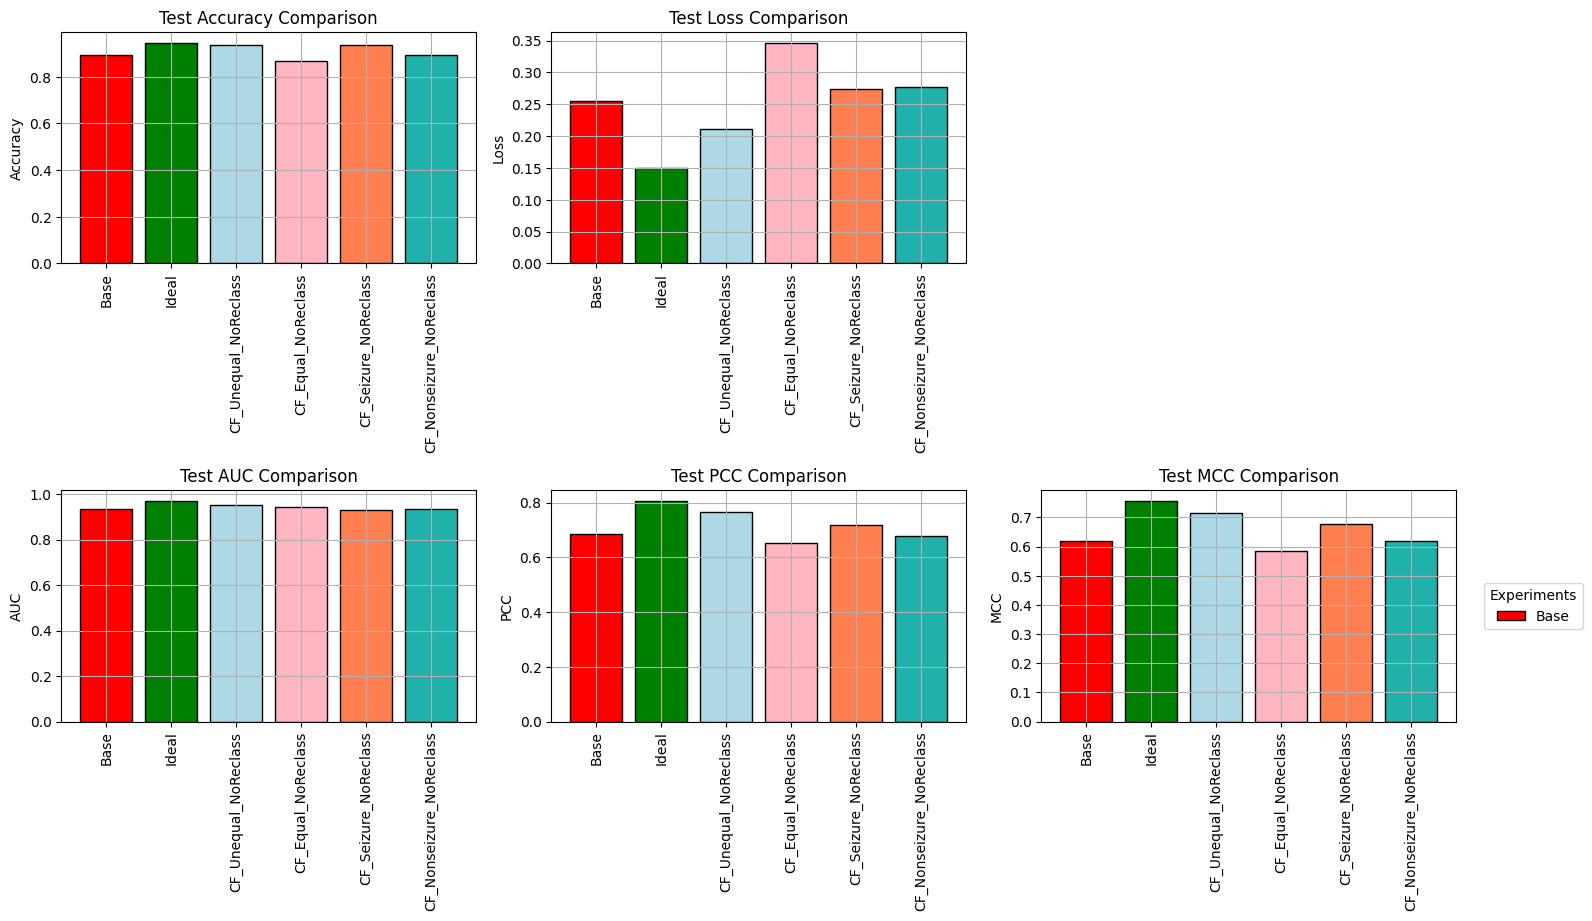

In [23]:
#store the performance metrics for each model
comparison_metrics = {
    'Model': [],
    'Name': [],
    'Test Accuracy': [],
    'Test Loss': [],
    'Test PCC': [],
    'Test MCC': [],
    'Test AUC': []
}

#evaluate the models
def eval_models(model, name):

    print(f'\nEvaluation of {name}')
    test_loss, test_acc = model.evaluate(test_seg, test_labels)
    #print(f"Test Loss: {test_loss*100:.4f}%")
    #print(f"Test Accuracy: {test_acc*100:.4f}%")

    #predictions and probabilities
    test_probs = model.predict(test_seg).ravel()
    test_preds = (test_probs > 0.5).astype(int)

    #Pearson correlation coefficient
    test_pcc = pearsonr(test_probs, test_labels)[0]
    #print(f"Pearson Correlation Coefficient of {name}: {test_pcc}")

    #Matthews correlation coefficient
    test_mcc = matthews_corrcoef(test_labels, test_preds)
    #print(f"Matthews Correlation Coefficient of {name}: {test_mcc}")

    #AUC-ROC
    test_auc = roc_auc_score(test_labels, test_probs)
    #print(f"AUC-ROC of {name}: {test_auc:.4f}")

    fpr, tpr, _ = roc_curve(test_labels, test_probs)

    #update the comparison table
    comparison_metrics['Model'].append(f'{name}')
    comparison_metrics['Test Accuracy'].append(test_acc)
    comparison_metrics['Test Loss'].append(test_loss)
    comparison_metrics['Test PCC'].append(test_pcc)
    comparison_metrics['Test MCC'].append(test_mcc)
    comparison_metrics['Test AUC'].append(test_auc)


eval_models(base_model, "Base Model")
eval_models(ideal_model, "Ideal Model")

eval_models(aug_model[1], "Exp 1 - Conf Thresh, Unequal Segments, no reclass")
eval_models(aug_model[2], "Exp 2 - Conf Thresh, Equal Segments, no reclass")
eval_models(aug_model[3], "Exp 3 - Conf Thresh, Seizure Segments, no reclass")
eval_models(aug_model[4], "Exp 4 - Conf Thresh, Non-Seizure Segments, no reclass")

#names for the models/experiments
short_names = ['Base',
               'Ideal',

               'CF_Unequal_NoReclass',
               'CF_Equal_NoReclass',
               'CF_Seizure_NoReclass',
               'CF_Nonseizure_NoReclass']

comparison_metrics['Name'] = short_names

#convert to df and save
comparison_df = pd.DataFrame(comparison_metrics)
print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))

comparison_df.to_csv('Exp(1-4)_Comparison_Results.csv', index=False)

#plot

#colors for each experiment/model
colors = ['red', 'green', 'lightblue', 'lightpink', 'coral', 'lightseagreen', 'gray', 'lavender', 'slateblue', 'teal', 'plum', 'lightsalmon', 'honeydew']

plt.figure(figsize=(16, 12))

#Test Accuracy
plt.subplot(3, 3, 1)
plt.bar(comparison_df['Name'], comparison_df['Test Accuracy'], color=colors, edgecolor='black')
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.grid(True)

#Test Loss
plt.subplot(3, 3, 2)
plt.bar(comparison_df['Name'], comparison_df['Test Loss'], color=colors, edgecolor='black')
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=90)
plt.grid(True)

#Test AUC
plt.subplot(3, 3, 4)
plt.bar(comparison_df['Name'], comparison_df['Test AUC'], color=colors, edgecolor='black')
plt.title('Test AUC Comparison')
plt.ylabel('AUC')
plt.xticks(rotation=90)
plt.grid(True)

#Test PCC
plt.subplot(3, 3, 5)
plt.bar(comparison_df['Name'], comparison_df['Test PCC'], color=colors, edgecolor='black')
plt.title('Test PCC Comparison')
plt.ylabel('PCC')
plt.xticks(rotation=90)
plt.grid(True)

#Test MCC
plt.subplot(3, 3, 6)
plt.bar(comparison_df['Name'], comparison_df['Test MCC'], color=colors, edgecolor='black')
plt.title('Test MCC Comparison')
plt.ylabel('MCC')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(short_names, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Experiments")

plt.tight_layout()
plt.show()

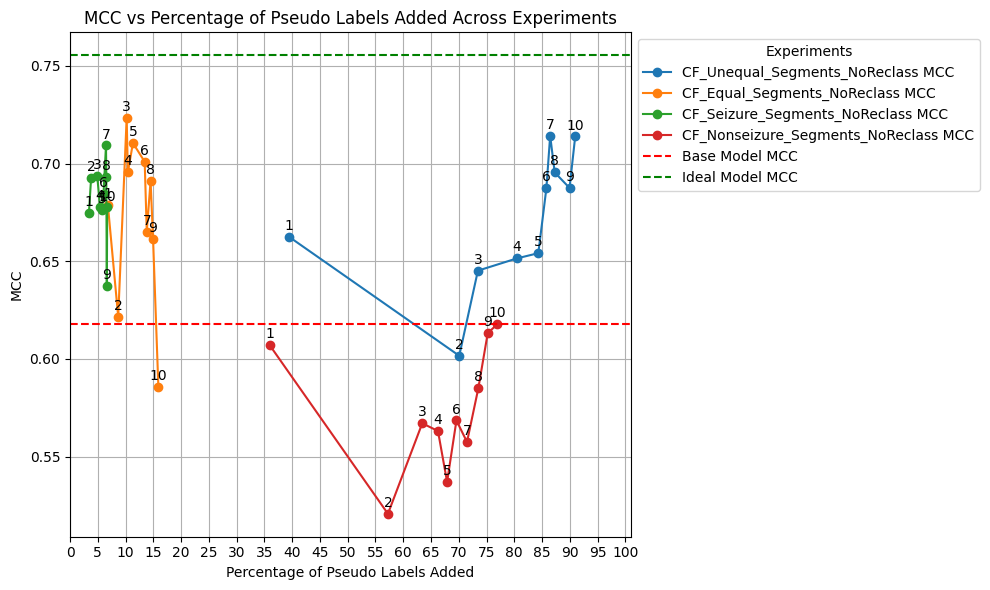

In [25]:
metrics_exp = {}

#load the performance metrics for each experiment
for i in range(1, 5):

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'CF_Unequal_Segments_NoReclass': metrics_exp[1],
    'CF_Equal_Segments_NoReclass': metrics_exp[2],
    'CF_Seizure_Segments_NoReclass': metrics_exp[3],
    'CF_Nonseizure_Segments_NoReclass': metrics_exp[4]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_auc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test AUC'].values[0]
ideal_auc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test AUC'].values[0]

base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)
#total_unlabelled = 50271

#track pseudo-labels, AUC, and MCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
mcc = {}

#iterate over the experiments
for exp_num, exp_name in enumerate(metrics_history.keys(), start=1):

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    mcc[exp_name] = metrics_history[exp_name]['Test MCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])
        #num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]
        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)


#plot MCC vs number/percentage of pseudo-labels added for each experiment
fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in metrics_history.keys():

    ax1.plot(perc_plabels[exp_name], mcc[exp_name], label=f'{exp_name} MCC', marker='o')

    #annotate each point with the iteration number
    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], mcc[exp_name][i]), textcoords="offset points", xytext=(0,5), ha='center')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#x-axis ticks in increments of 5%
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_xlim([0, 101])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added Across Experiments')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()

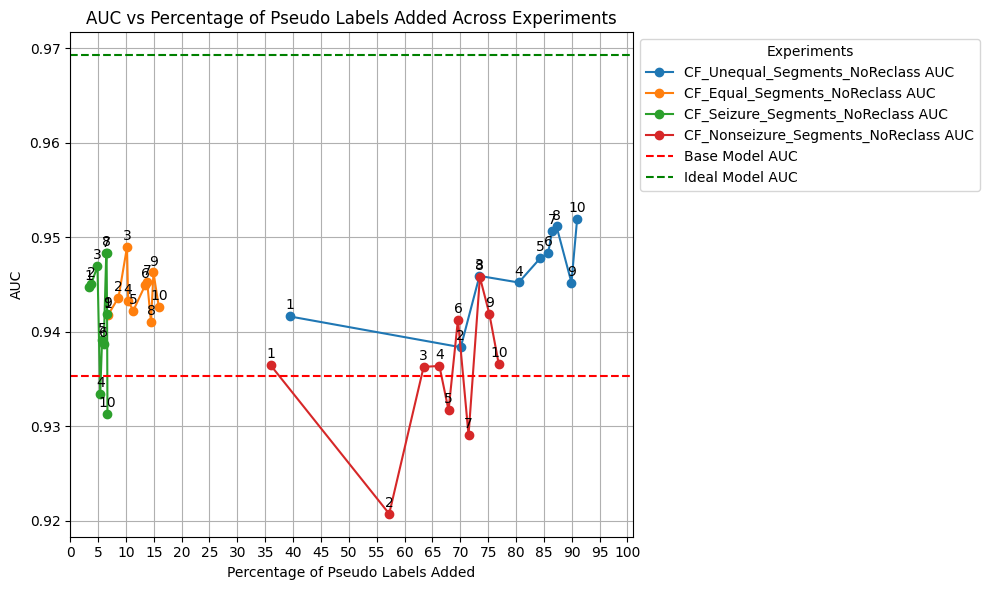

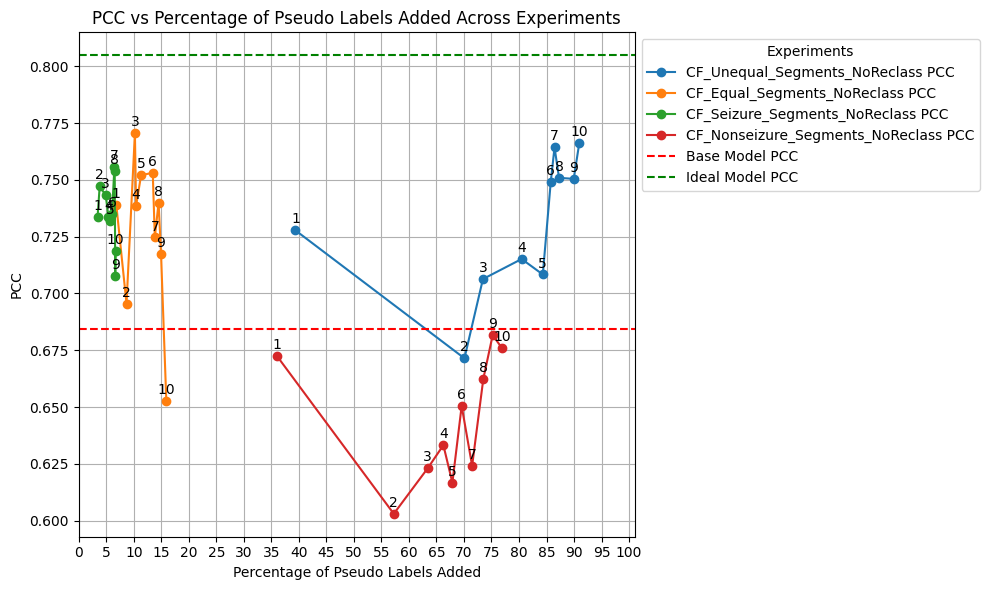

In [26]:
metrics_exp = {}

#load the performance metrics for each experiment
for i in range(1, 5):

    metrics_exp[i] = pd.read_csv(f'Performance_Metrics_Exp{i}.csv')

#store the loaded data in a dictionary
metrics_history = {
    'CF_Unequal_Segments_NoReclass': metrics_exp[1],
    'CF_Equal_Segments_NoReclass': metrics_exp[2],
    'CF_Seizure_Segments_NoReclass': metrics_exp[3],
    'CF_Nonseizure_Segments_NoReclass': metrics_exp[4]
}

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract AUC and MCC values for the base and ideal models
base_auc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test AUC'].values[0]
ideal_auc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test AUC'].values[0]

base_pcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test PCC'].values[0]
ideal_pcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test PCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)
#total_unlabelled = 50271

#track pseudo-labels, AUC, PCC for each experiment
num_plabels = {}
perc_plabels = {}
auc = {}
pcc = {}

#iterate over the experiments
for exp_num, exp_name in enumerate(metrics_history.keys(), start=1):

    num_plabels[exp_name] = []
    perc_plabels[exp_name] = []

    auc[exp_name] = metrics_history[exp_name]['Test AUC']
    pcc[exp_name] = metrics_history[exp_name]['Test PCC']

    for i in range(len(metrics_history[exp_name]['Iteration'])):

        #number of pseudo-labels added
        num_l = sum(metrics_history[exp_name]['Number of Confident Indices Added'][:i + 1])
        #num_l = metrics_history[exp_name]['Number of Confident Indices Added'][i]
        num_plabels[exp_name].append(num_l)

        #percentage of pseudo-labels added
        perc_l = (num_l / total_unlabelled) * 100
        perc_plabels[exp_name].append(perc_l)

#plot AUC vs number/percentage of pseudo-labels added for each experiment
fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in metrics_history.keys():

    ax1.plot(perc_plabels[exp_name], auc[exp_name], label=f'{exp_name} AUC', marker='o')

    #annotate each point with the iteration number
    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], auc[exp_name][i]), textcoords="offset points", xytext=(0,5), ha='center')

#base model and ideal model AUC baseline references
ax1.axhline(y=base_auc, color='red', linestyle='--', label='Base Model AUC')
ax1.axhline(y=ideal_auc, color='green', linestyle='--', label='Ideal Model AUC')

#x-axis ticks in increments of 5%
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_xlim([0, 101])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('AUC')

ax1.set_title('AUC vs Percentage of Pseudo Labels Added Across Experiments')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()

#plot PCC vs number/percentage of pseudo-labels added for each experiment
fig, ax1 = plt.subplots(figsize=(10, 6))

for exp_name in metrics_history.keys():

    ax1.plot(perc_plabels[exp_name], pcc[exp_name], label=f'{exp_name} PCC', marker='o')

    #annotate each point with the iteration number
    for i, txt in enumerate(metrics_history[exp_name]['Iteration']):

        ax1.annotate(txt, (perc_plabels[exp_name][i], pcc[exp_name][i]), textcoords="offset points", xytext=(0,5), ha='center')

#base model and ideal model pCC baseline references
ax1.axhline(y=base_pcc, color='red', linestyle='--', label='Base Model PCC')
ax1.axhline(y=ideal_pcc, color='green', linestyle='--', label='Ideal Model PCC')

#x-axis ticks in increments of 5%
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_xlim([0, 101])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('PCC')

ax1.set_title('PCC vs Percentage of Pseudo Labels Added Across Experiments')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Experiments")

plt.tight_layout()
plt.show()

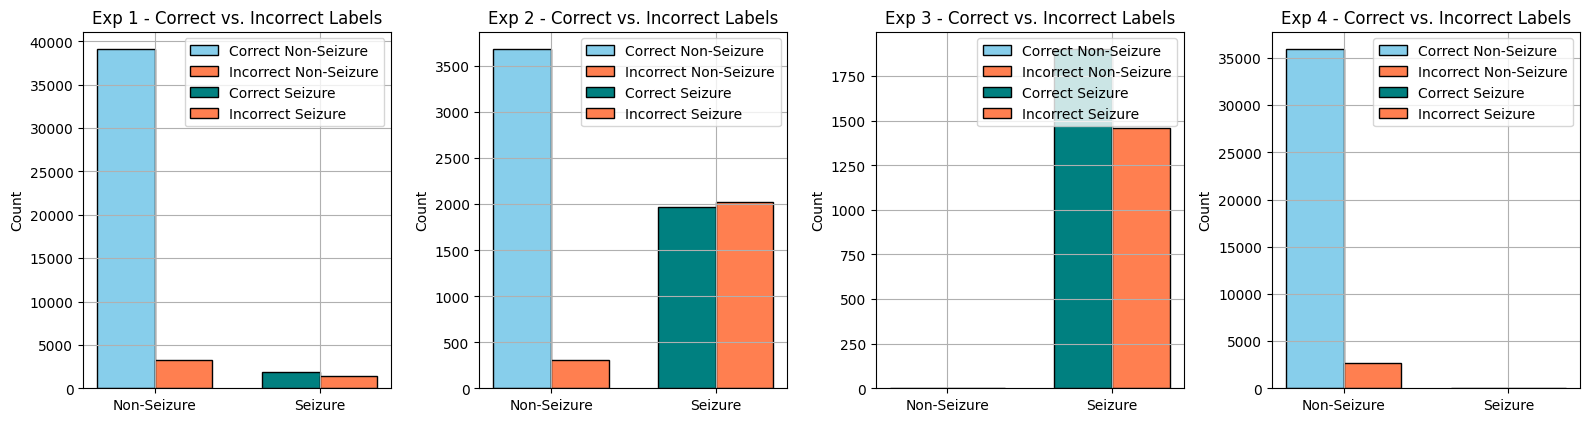

In [28]:
#function to count correct and incorrect labels
def count_labels(pseudo_labels, actual_labels):

    correct_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 1))

    incorrect_seizure = np.sum((pseudo_labels == 1) & (actual_labels == 0))

    correct_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 0))

    incorrect_nonseizure = np.sum((pseudo_labels == 0) & (actual_labels == 1))

    return correct_seizure, incorrect_seizure, correct_nonseizure, incorrect_nonseizure


def get_labels(pseudo_labelled_segments):

    pseudo_indices = np.array(pseudo_labelled_segments['Indices'])

    pseudo_labels = np.array(pseudo_labelled_segments['Predicted Labels'])

    actual_labels = y_train_unlabels[pseudo_indices]

    return pseudo_labels, actual_labels

#dictionaries to store results for each experiment
correct_seizure = {}
incorrect_seizure = {}
correct_nonseizure = {}
incorrect_nonseizure = {}

#load the pseudo labelled segments for each experiment

for i in range(1, 5):

    pseudo_labelled_segments_df = pd.read_csv(f'Pseudo_Labels_Exp{i}.csv')

    pseudo_labels, actual_labels = get_labels(pseudo_labelled_segments_df)

    #count the correct and incorrect labels for each experiment
    correct_seizure[i], incorrect_seizure[i], correct_nonseizure[i], incorrect_nonseizure[i] = count_labels(pseudo_labels, actual_labels)

#plotting the results
bw = 0.35
index = np.arange(2)  #for 2 classes

plt.figure(figsize=(16, 12))

for i in range(1, 5):

    #exp i
        plt.subplot(3, 4, i)

        plt.bar(index[0] - bw / 2, correct_nonseizure[i], bw, color='skyblue', edgecolor='black', label='Correct Non-Seizure')
        plt.bar(index[0] + bw / 2, incorrect_nonseizure[i], bw, color='coral', edgecolor='black', label='Incorrect Non-Seizure')
        plt.bar(index[1] - bw / 2, correct_seizure[i], bw, color='teal', edgecolor='black', label='Correct Seizure')
        plt.bar(index[1] + bw / 2, incorrect_seizure[i], bw, color='coral', edgecolor='black', label='Incorrect Seizure')

        plt.xticks(index, ['Non-Seizure', 'Seizure'])
        plt.title(f'Exp {i} - Correct vs. Incorrect Labels')
        plt.ylabel('Count')
        plt.legend(loc='upper right')
        plt.grid(True)

plt.tight_layout()
plt.show()

# PCC and MCC Plot For Each Experiment

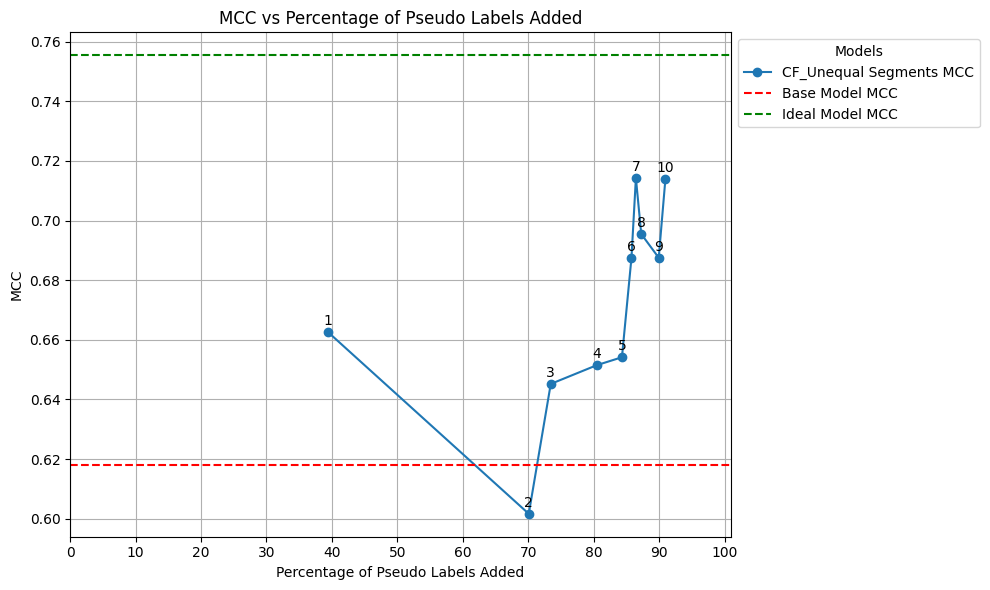

In [37]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp1.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, MCC for Experiment
num_plabels = []
perc_plabels = []

mcc = metrics_exp['Test MCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot MCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, mcc, label='CF_Unequal Segments MCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], mcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 10, 10))
ax1.set_xlim([0, np.ceil(max_perc) + 10])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

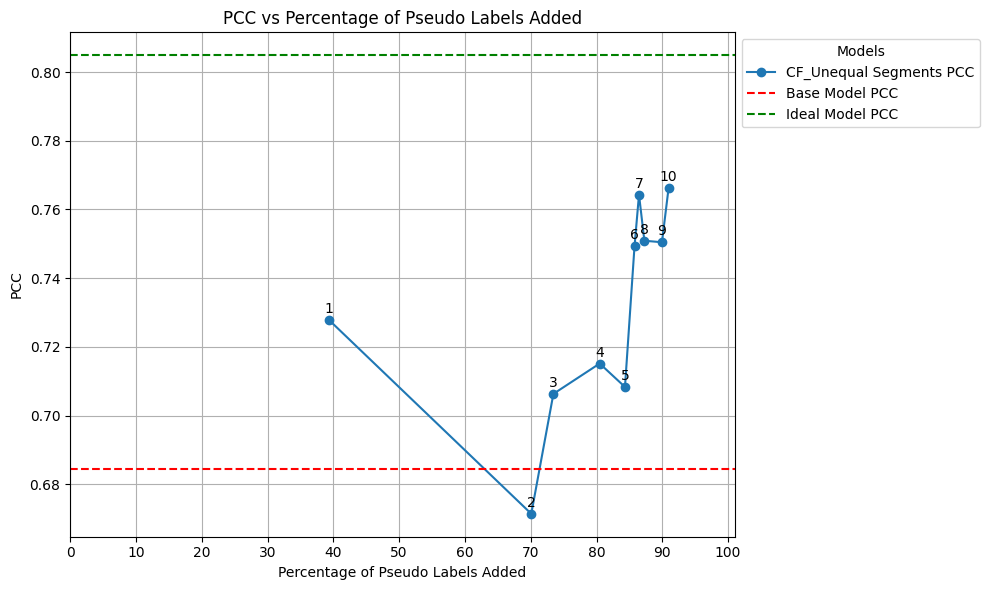

In [38]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp1.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract PCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test PCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test PCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, PCC for Experiment
num_plabels = []
perc_plabels = []

pcc = metrics_exp['Test PCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot PCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, pcc, label='CF_Unequal Segments PCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], pcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model PCC baseline references
ax1.axhline(y=base_pcc, color='red', linestyle='--', label='Base Model PCC')
ax1.axhline(y=ideal_pcc, color='green', linestyle='--', label='Ideal Model PCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 10, 10))
ax1.set_xlim([0, np.ceil(max_perc) + 10])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('PCC')

ax1.set_title('PCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

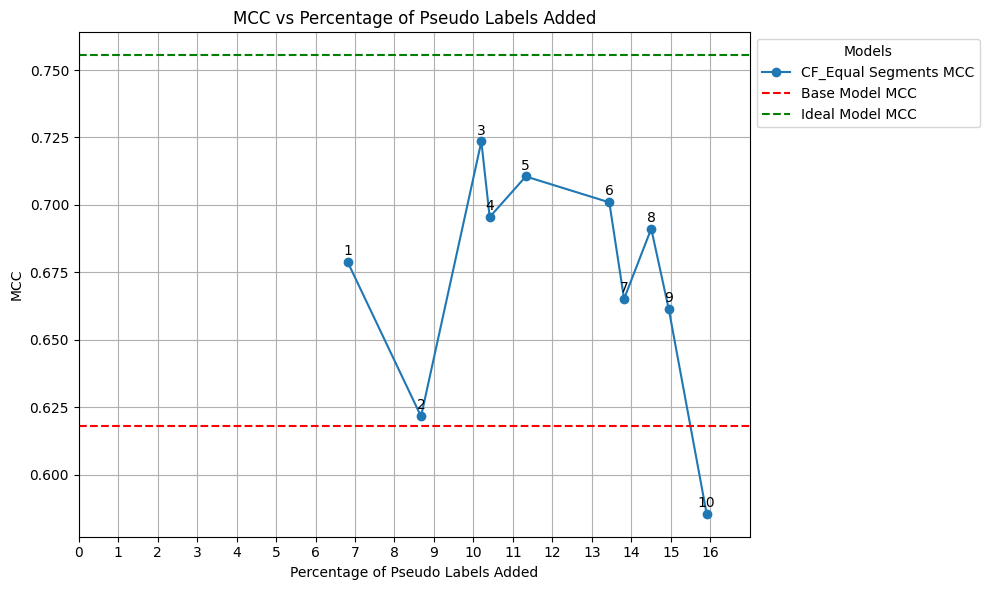

In [39]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp2.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, MCC for Experiment
num_plabels = []
perc_plabels = []

mcc = metrics_exp['Test MCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot MCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, mcc, label='CF_Equal Segments MCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], mcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 1, 1))
ax1.set_xlim([0, np.ceil(max_perc) + 1])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

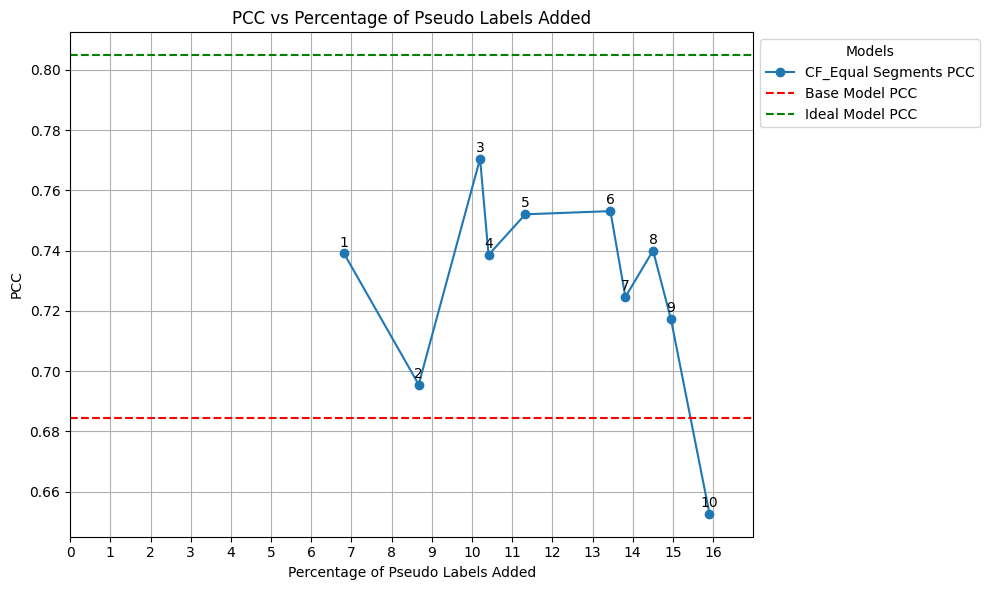

In [45]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp2.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract PCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test PCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test PCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, PCC for Experiment
num_plabels = []
perc_plabels = []

pcc = metrics_exp['Test PCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot PCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, pcc, label='CF_Equal Segments PCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], pcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model PCC baseline references
ax1.axhline(y=base_pcc, color='red', linestyle='--', label='Base Model PCC')
ax1.axhline(y=ideal_pcc, color='green', linestyle='--', label='Ideal Model PCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 1, 1))
ax1.set_xlim([0, np.ceil(max_perc) + 1])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('PCC')

ax1.set_title('PCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

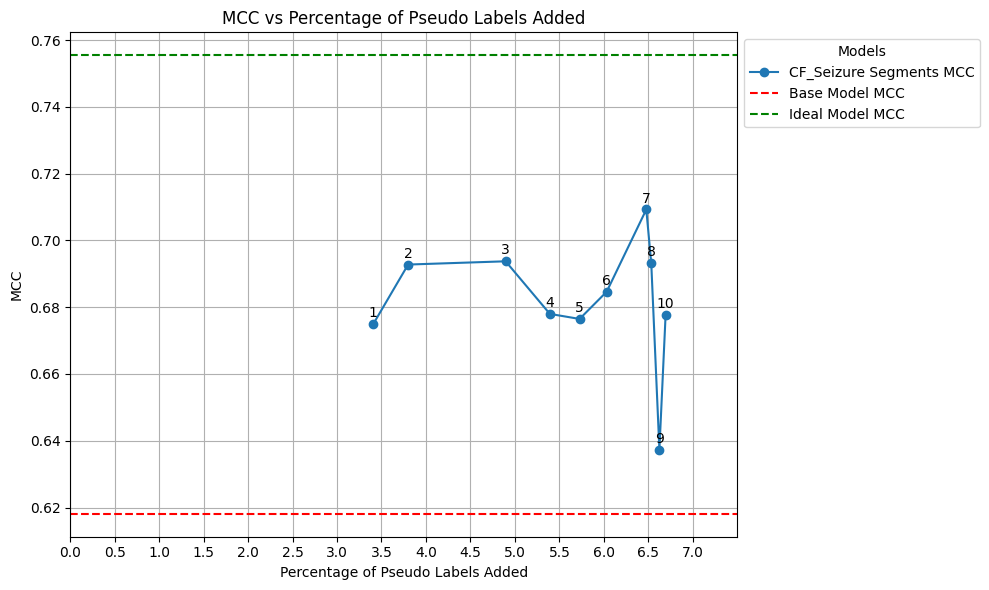

In [48]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp3.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, MCC for Experiment
num_plabels = []
perc_plabels = []

mcc = metrics_exp['Test MCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot MCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, mcc, label='CF_Seizure Segments MCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], mcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 0.5, 0.5))
ax1.set_xlim([0, np.ceil(max_perc) + 0.5])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

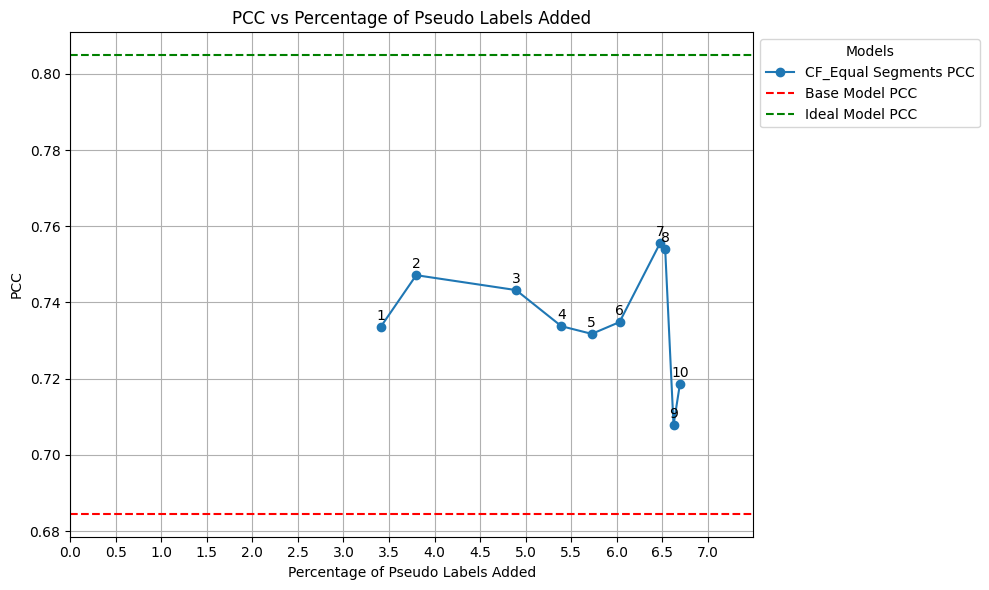

In [49]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp3.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract PCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test PCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test PCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, PCC for Experiment
num_plabels = []
perc_plabels = []

pcc = metrics_exp['Test PCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot PCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, pcc, label='CF_Equal Segments PCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], pcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model PCC baseline references
ax1.axhline(y=base_pcc, color='red', linestyle='--', label='Base Model PCC')
ax1.axhline(y=ideal_pcc, color='green', linestyle='--', label='Ideal Model PCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 0.5, 0.5))
ax1.set_xlim([0, np.ceil(max_perc) + 0.5])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('PCC')

ax1.set_title('PCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

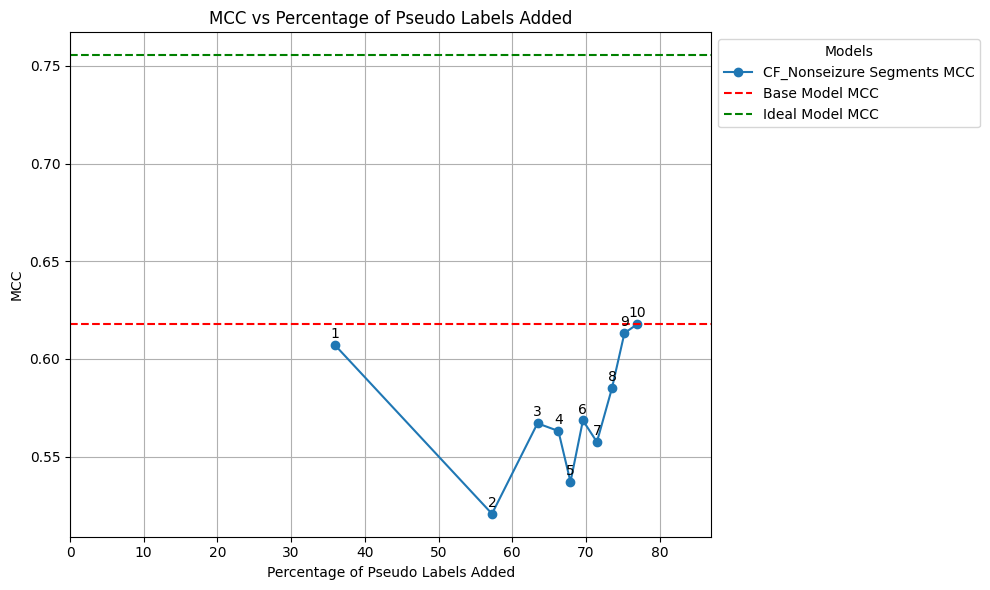

In [43]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp4.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract MCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test MCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test MCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, MCC for Experiment
num_plabels = []
perc_plabels = []

mcc = metrics_exp['Test MCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot MCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, mcc, label='CF_Nonseizure Segments MCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], mcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model MCC baseline references
ax1.axhline(y=base_mcc, color='red', linestyle='--', label='Base Model MCC')
ax1.axhline(y=ideal_mcc, color='green', linestyle='--', label='Ideal Model MCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 10, 10))
ax1.set_xlim([0, np.ceil(max_perc) + 10])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('MCC')

ax1.set_title('MCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()

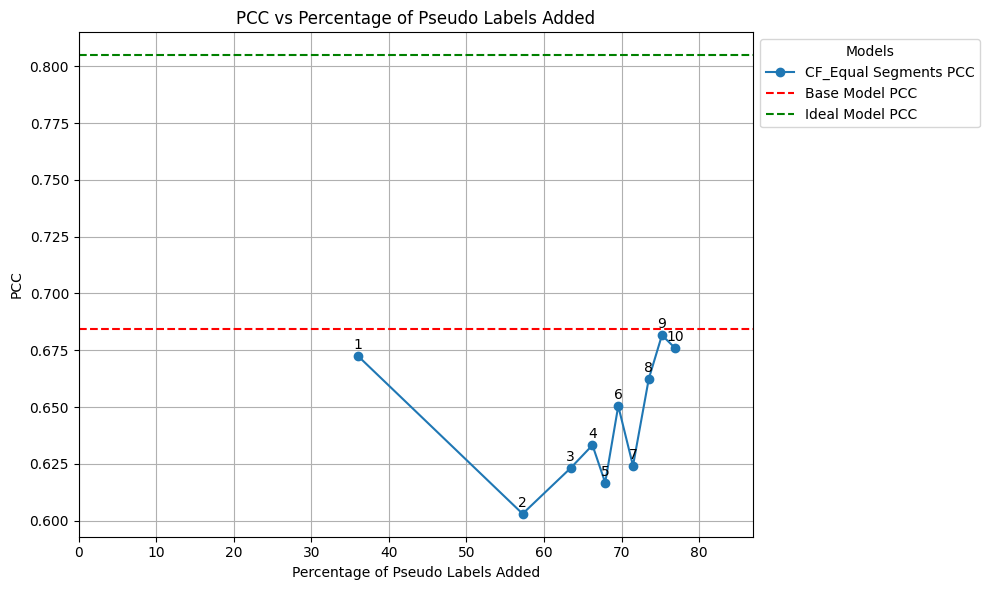

In [44]:
#load the performance metrics for Experiment
metrics_exp = pd.read_csv('Performance_Metrics_Exp4.csv')

#load the performance metrics for the base and ideal models
comparison_metrics = pd.read_csv('Exp(1-4)_Comparison_Results.csv')

#extract PCC values for the base and ideal models
base_mcc = comparison_metrics[comparison_metrics['Model'] == 'Base Model']['Test PCC'].values[0]
ideal_mcc = comparison_metrics[comparison_metrics['Model'] == 'Ideal Model']['Test PCC'].values[0]

#total number of unlabeled data
total_unlabelled = len(y_train_unlabels)

#track pseudo-labels, PCC for Experiment
num_plabels = []
perc_plabels = []

pcc = metrics_exp['Test PCC']

#iterate over the iterations in Experiment
for i in range(len(metrics_exp['Iteration'])):

    #cumulative number of pseudo-labels added
    num_l = sum(metrics_exp['Number of Confident Indices Added'][:i + 1])
    num_plabels.append(num_l)

    #percentage of pseudo-labels added
    perc_l = (num_l / total_unlabelled) * 100
    perc_plabels.append(perc_l)

#plot PCC
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(perc_plabels, pcc, label='CF_Equal Segments PCC', marker='o')

#annotate each point with the iteration number
for i, txt in enumerate(metrics_exp['Iteration']):
    ax1.annotate(txt, (perc_plabels[i], pcc[i]), textcoords="offset points", xytext=(0, 5), ha='center')

#base model and ideal model PCC baseline references
ax1.axhline(y=base_pcc, color='red', linestyle='--', label='Base Model PCC')
ax1.axhline(y=ideal_pcc, color='green', linestyle='--', label='Ideal Model PCC')

#x-axis limits and ticks
min_perc = min(perc_plabels)
max_perc = max(perc_plabels)

ax1.set_xticks(np.arange(0, np.ceil(max_perc) + 10, 10))
ax1.set_xlim([0, np.ceil(max_perc) + 10])

ax1.set_xlabel('Percentage of Pseudo Labels Added')
ax1.set_ylabel('PCC')

ax1.set_title('PCC vs Percentage of Pseudo Labels Added')
ax1.grid(True)

ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models")

plt.tight_layout()
plt.show()